In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from google.colab import drive 
from scipy.stats import norm
from scipy import stats
from numpy import nan
#Sklearn
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from joblib import dump, load
from sklearn import svm
import csv
#Tensorflow
import tensorflow as tf
# DT
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [130]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos los modelos finales

In [62]:
oneHot = OneHotEncoder()

In [127]:
tree = load("models2/decision_tree_entropy_md=7_msl_15.joblib")
svm_clf = load("models2/linear_svm.joblib")
bayes = load("models2/gaussian_bayes.joblib")
log_reg_m = np.load("models2/str_m.npy")
log_reg_b = np.load("models2/str_b.npy")

In [32]:
data = pd.read_csv('data_filtered.csv')

In [110]:
x_test = resample(data, n_samples = 10)
x_test
y_test = x_test.pop('passenger_survived')

## Valor verdadero

In [151]:
y_test

534    0
308    0
226    1
382    0
262    0
217    0
631    0
756    0
297    0
755    1
Name: passenger_survived, dtype: int64

In [112]:
y_test_reshaped = y_test.values.reshape((y_test.shape[0], 1))
oneHot = OneHotEncoder()
oneHot.fit(y_test_reshaped)
y_test_transformed = oneHot.transform(y_test_reshaped).toarray()

In [50]:
def predict_logistic_regression(x_test, weights, bias):

    sc= StandardScaler()
    x_test_scaled = sc.fit_transform(x_test)  

    tf.reset_default_graph()
    
    W = tf.placeholder(tf.float32, shape = [None, None], name = "W")
    b = tf.placeholder(tf.float32, shape = [None, None], name = "X")
    x = tf.placeholder(tf.float32, shape = [None, None], name = "bias")
    
    logits = tf.add(tf.matmul(x, W), b)
    sigmoid = tf.nn.sigmoid(logits)
    prediction = tf.round(sigmoid)
    
    with tf.train.MonitoredSession() as session:
        feed_dictionary = {x: x_test_scaled, W:weights, b:bias}
        
        pred, probs = session.run([prediction, sigmoid], feed_dict= feed_dictionary)
        
        return pred, probs

In [140]:
def predict_y(x_test):
  
  #Arbol de decision
  tree_y_pred= tree.predict(x_test)

  # SVM
  svm_y_pred = svm_clf.predict(x_test)

  # Bayes
  bayes_y_pred = bayes.predict(x_test)

  #logistic reg
  reg_y_pred,_ =  predict_logistic_regression(x_test, log_reg_m, log_reg_b)
  reg_y_pred =  oneHot.inverse_transform(reg_y_pred)


  y_preds = np.stack((tree_y_pred.reshape(x_test.shape[0],1),
                    svm_y_pred.reshape(x_test.shape[0],1), 
                    bayes_y_pred.reshape(x_test.shape[0],1), 
                    reg_y_pred)).T


  final_pred = stats.mode(y_preds[0], axis=1)

  return final_pred[0]



In [139]:
column_names = list(x_test.columns)
column_names


['Age',
 'SibSp',
 'Parch',
 'Fare',
 'passenger_sex_F',
 'passenger_sex_M',
 'passenger_class_Lower',
 'passenger_class_Middle',
 'passenger_class_Upper',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

## Prueba de 10 observaciones

In [114]:
x_test.shape

(10, 12)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediccion: [[0]]
INFO:tensorflow:Graph was f

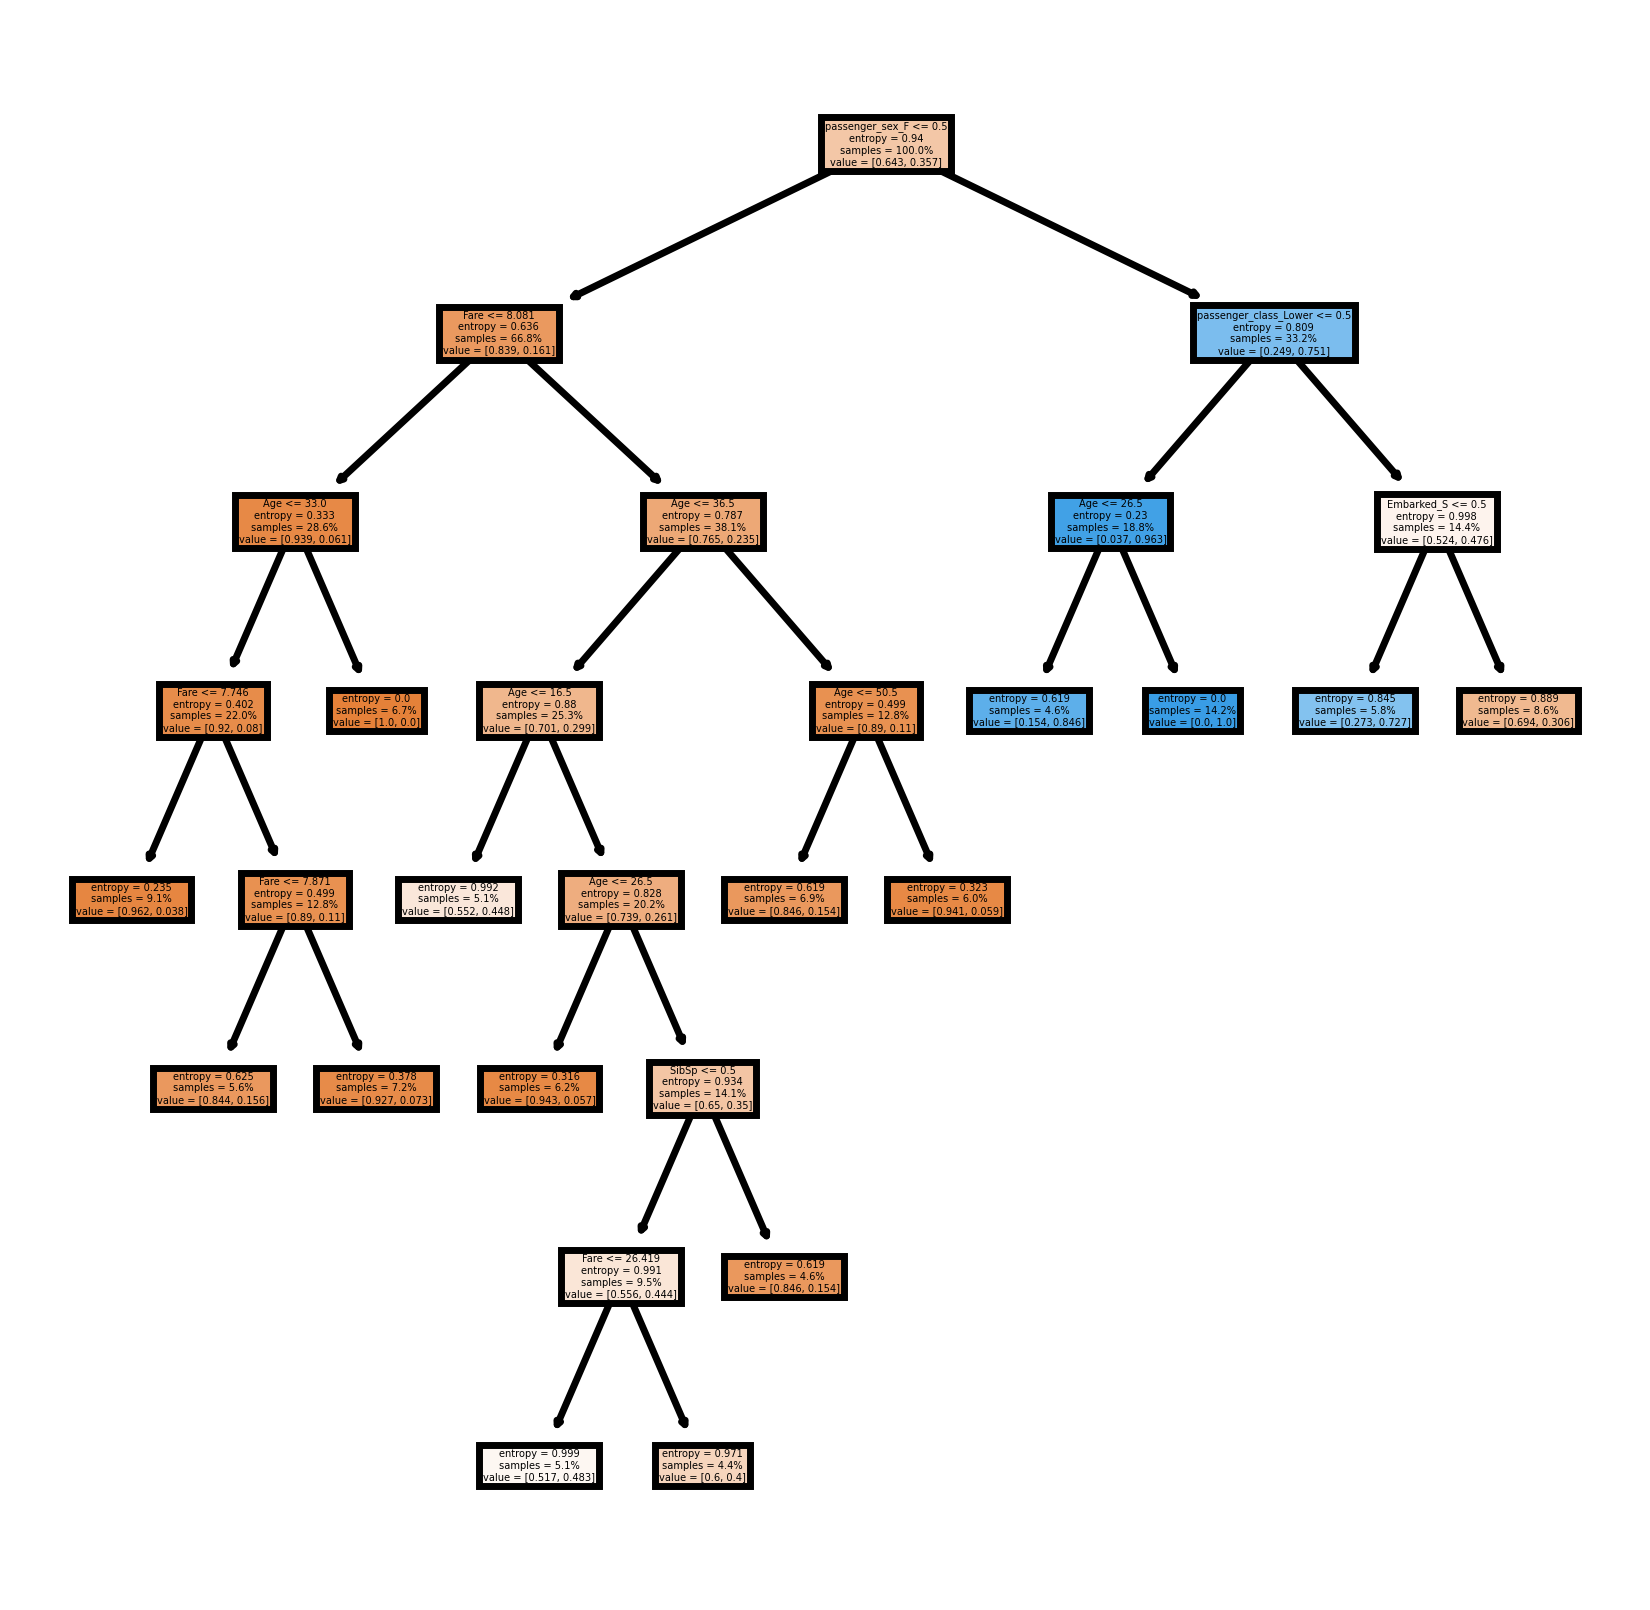

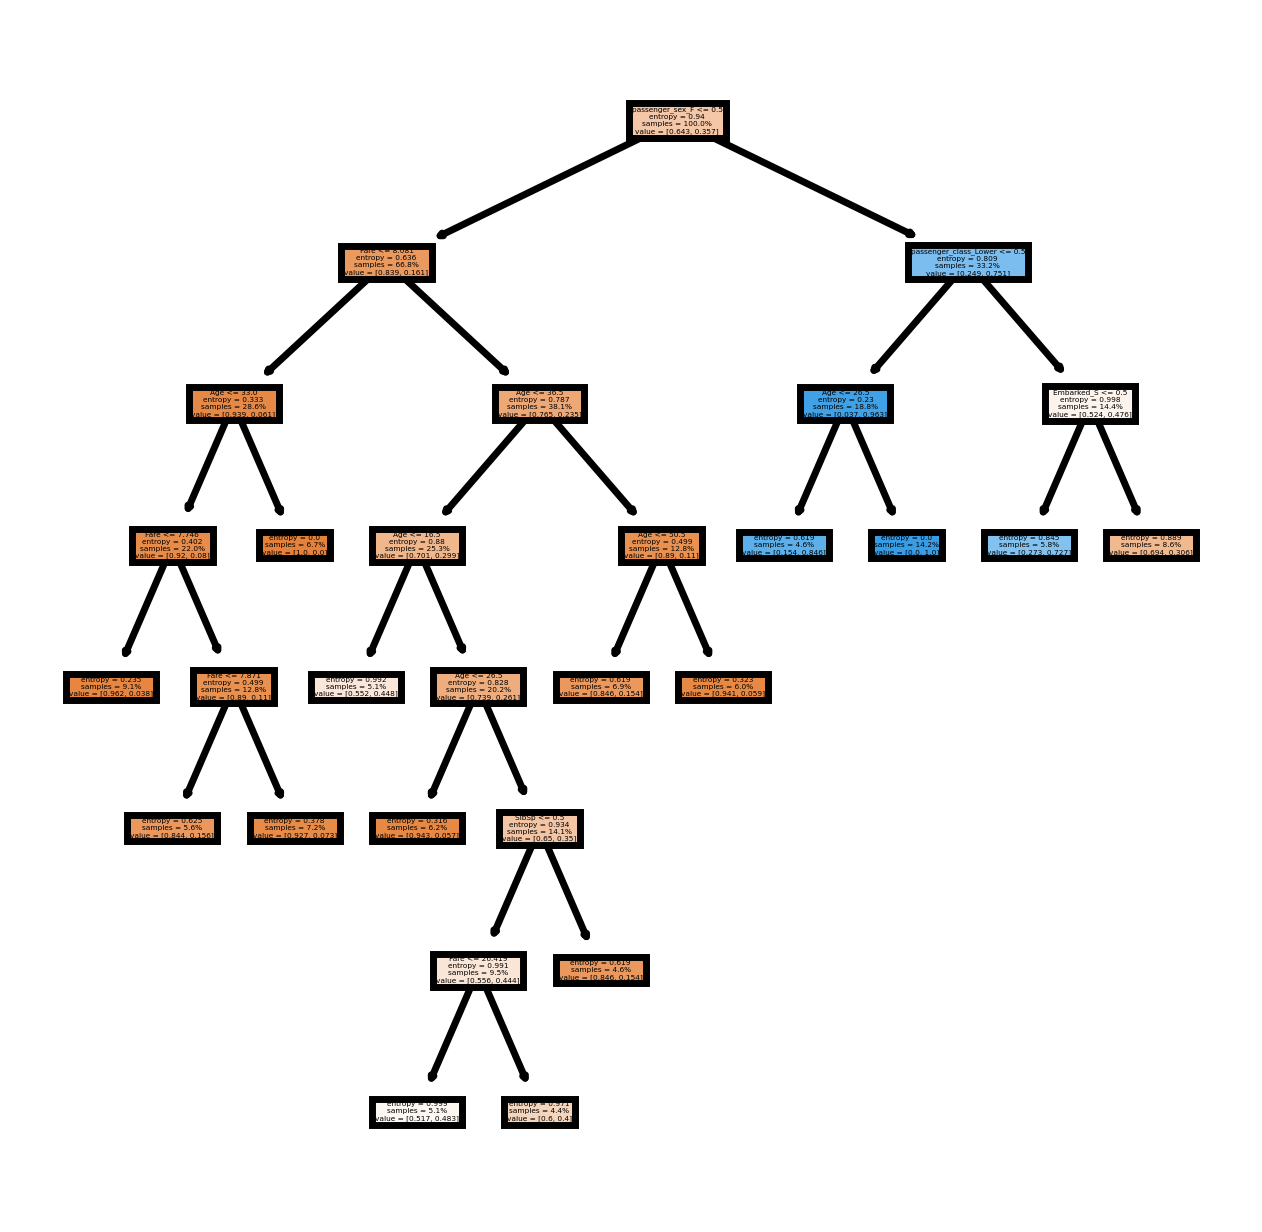

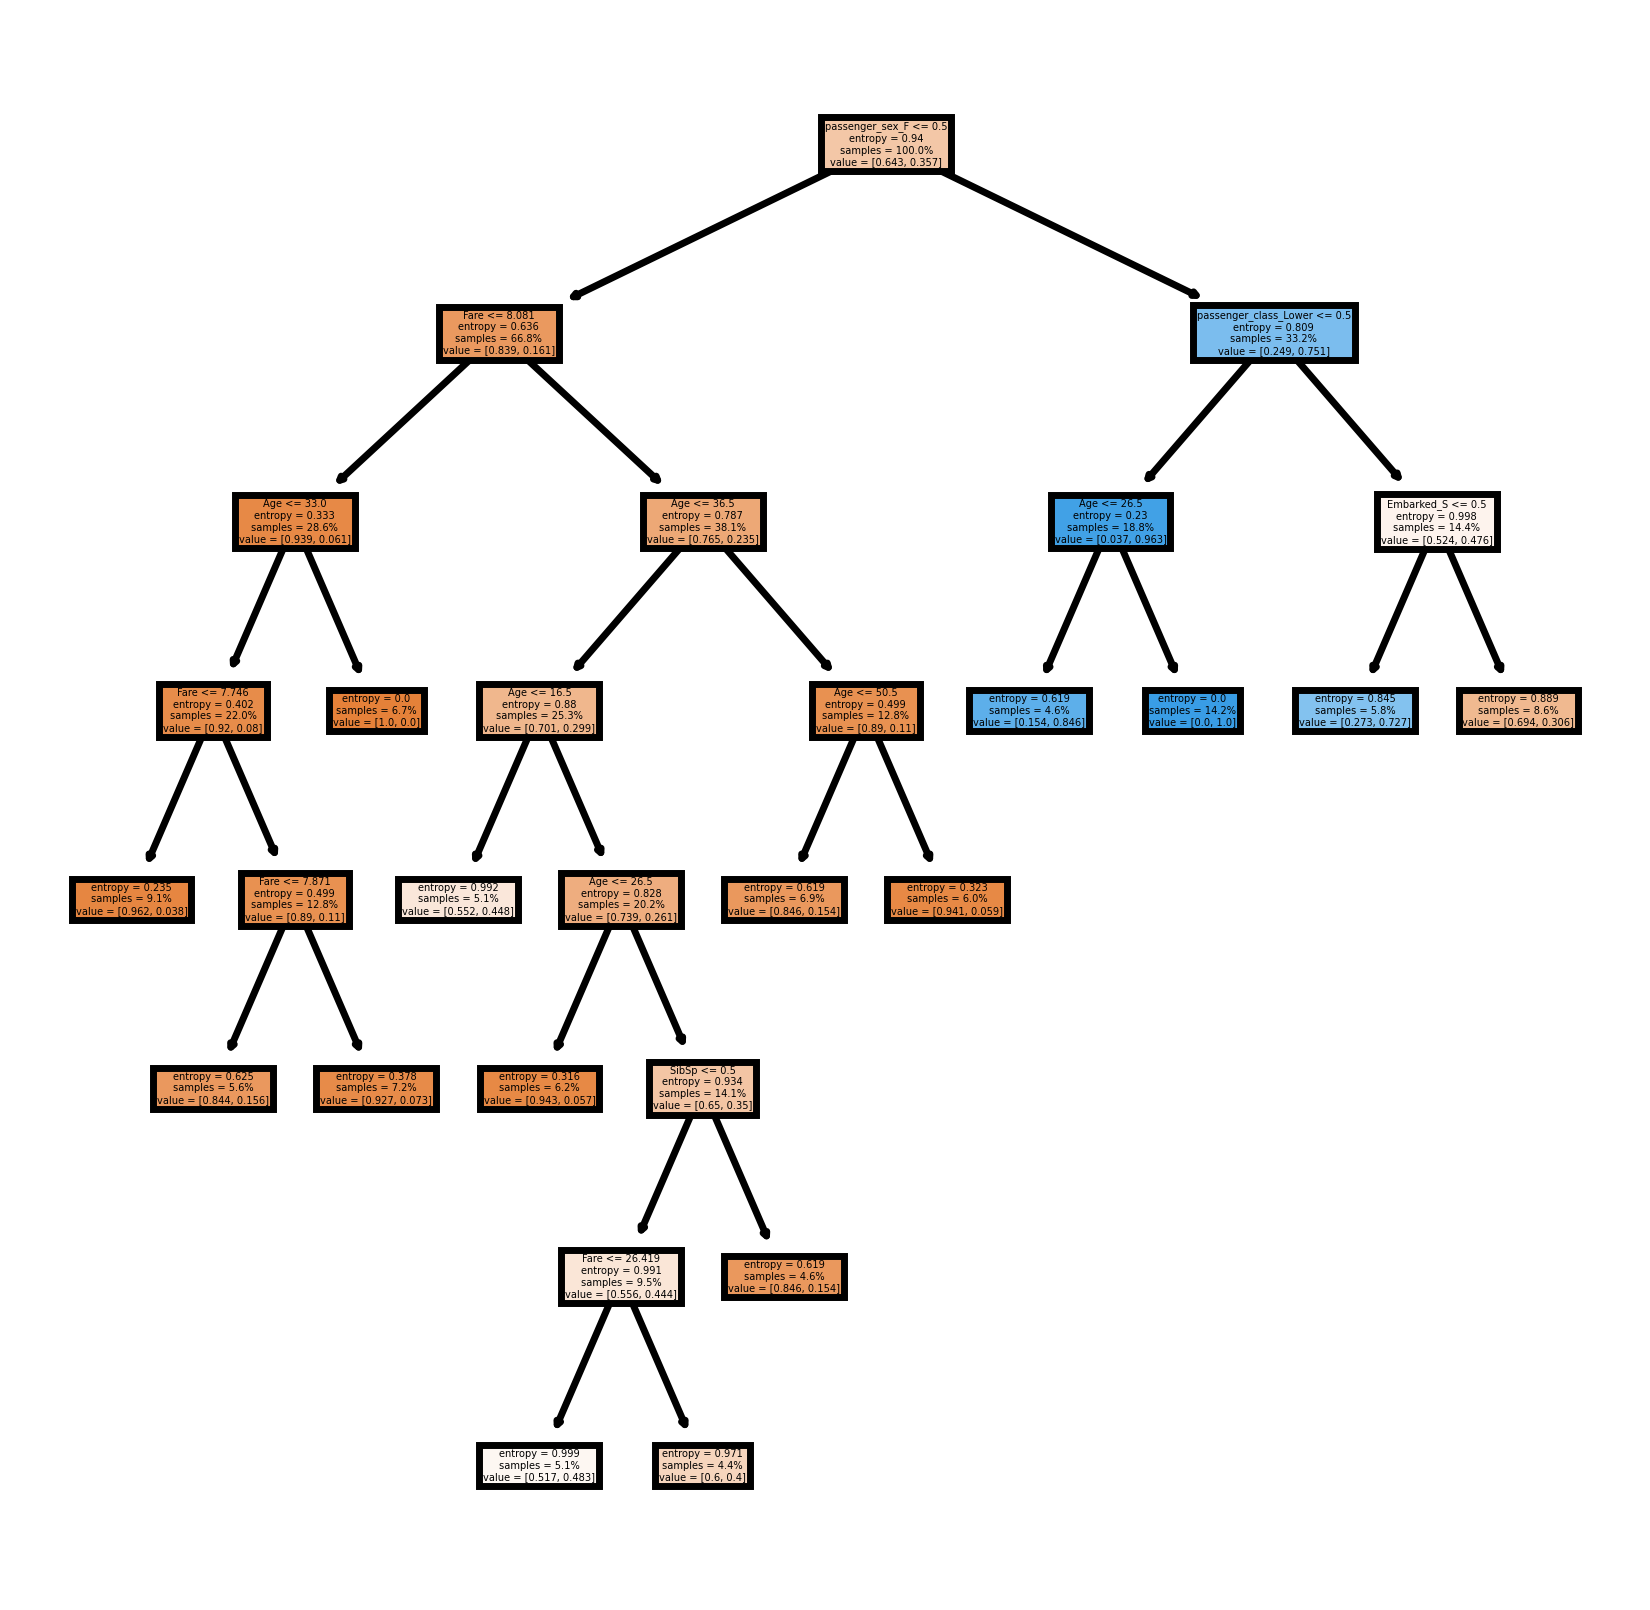

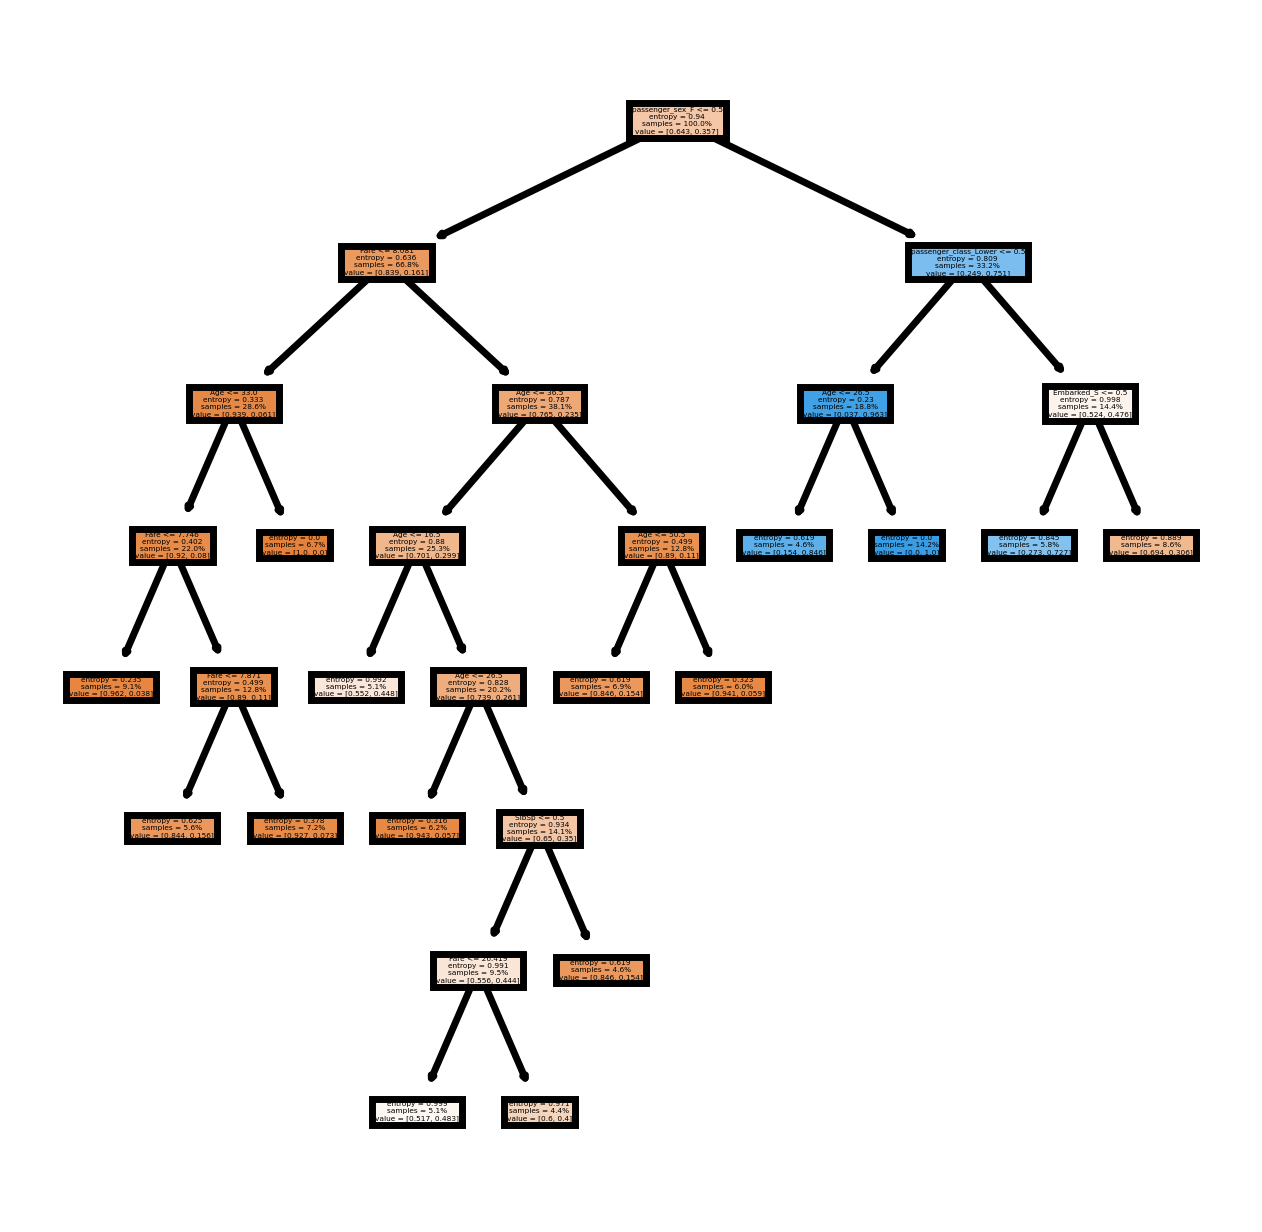

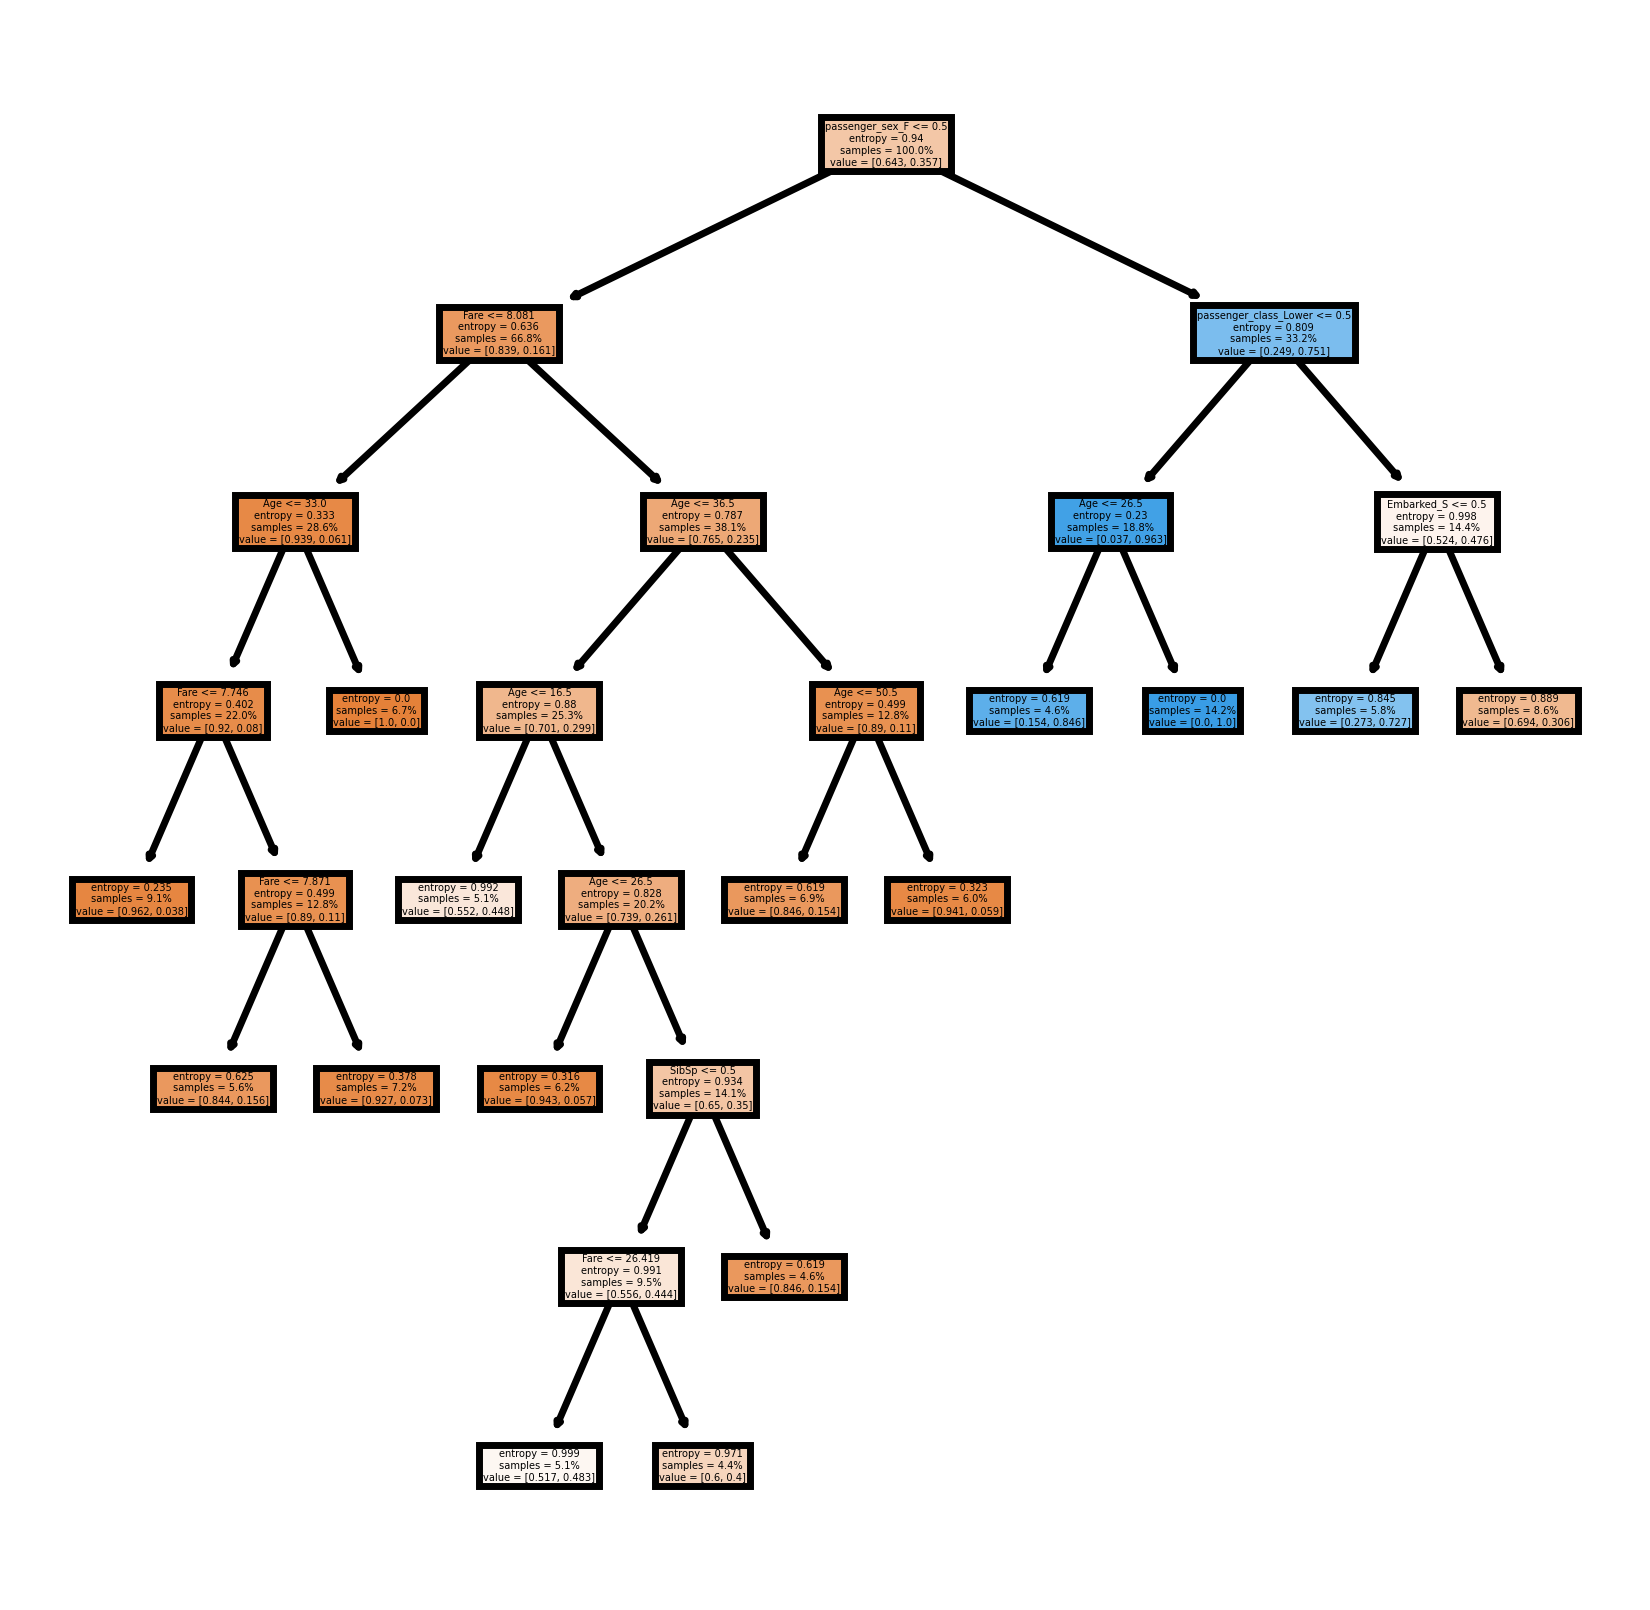

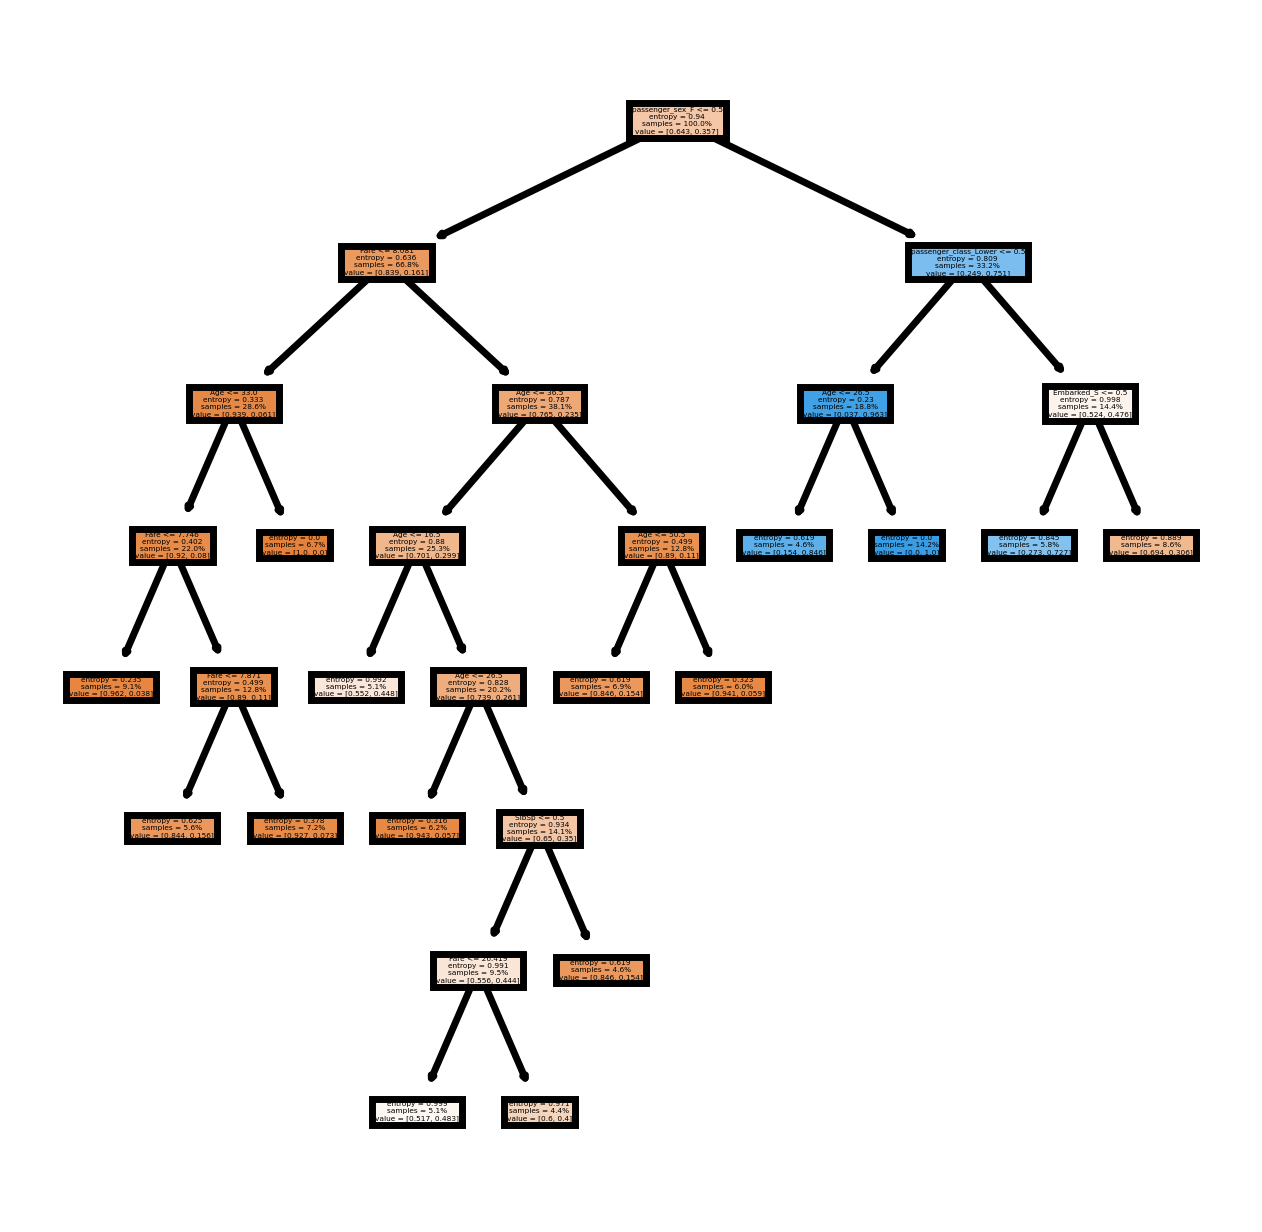

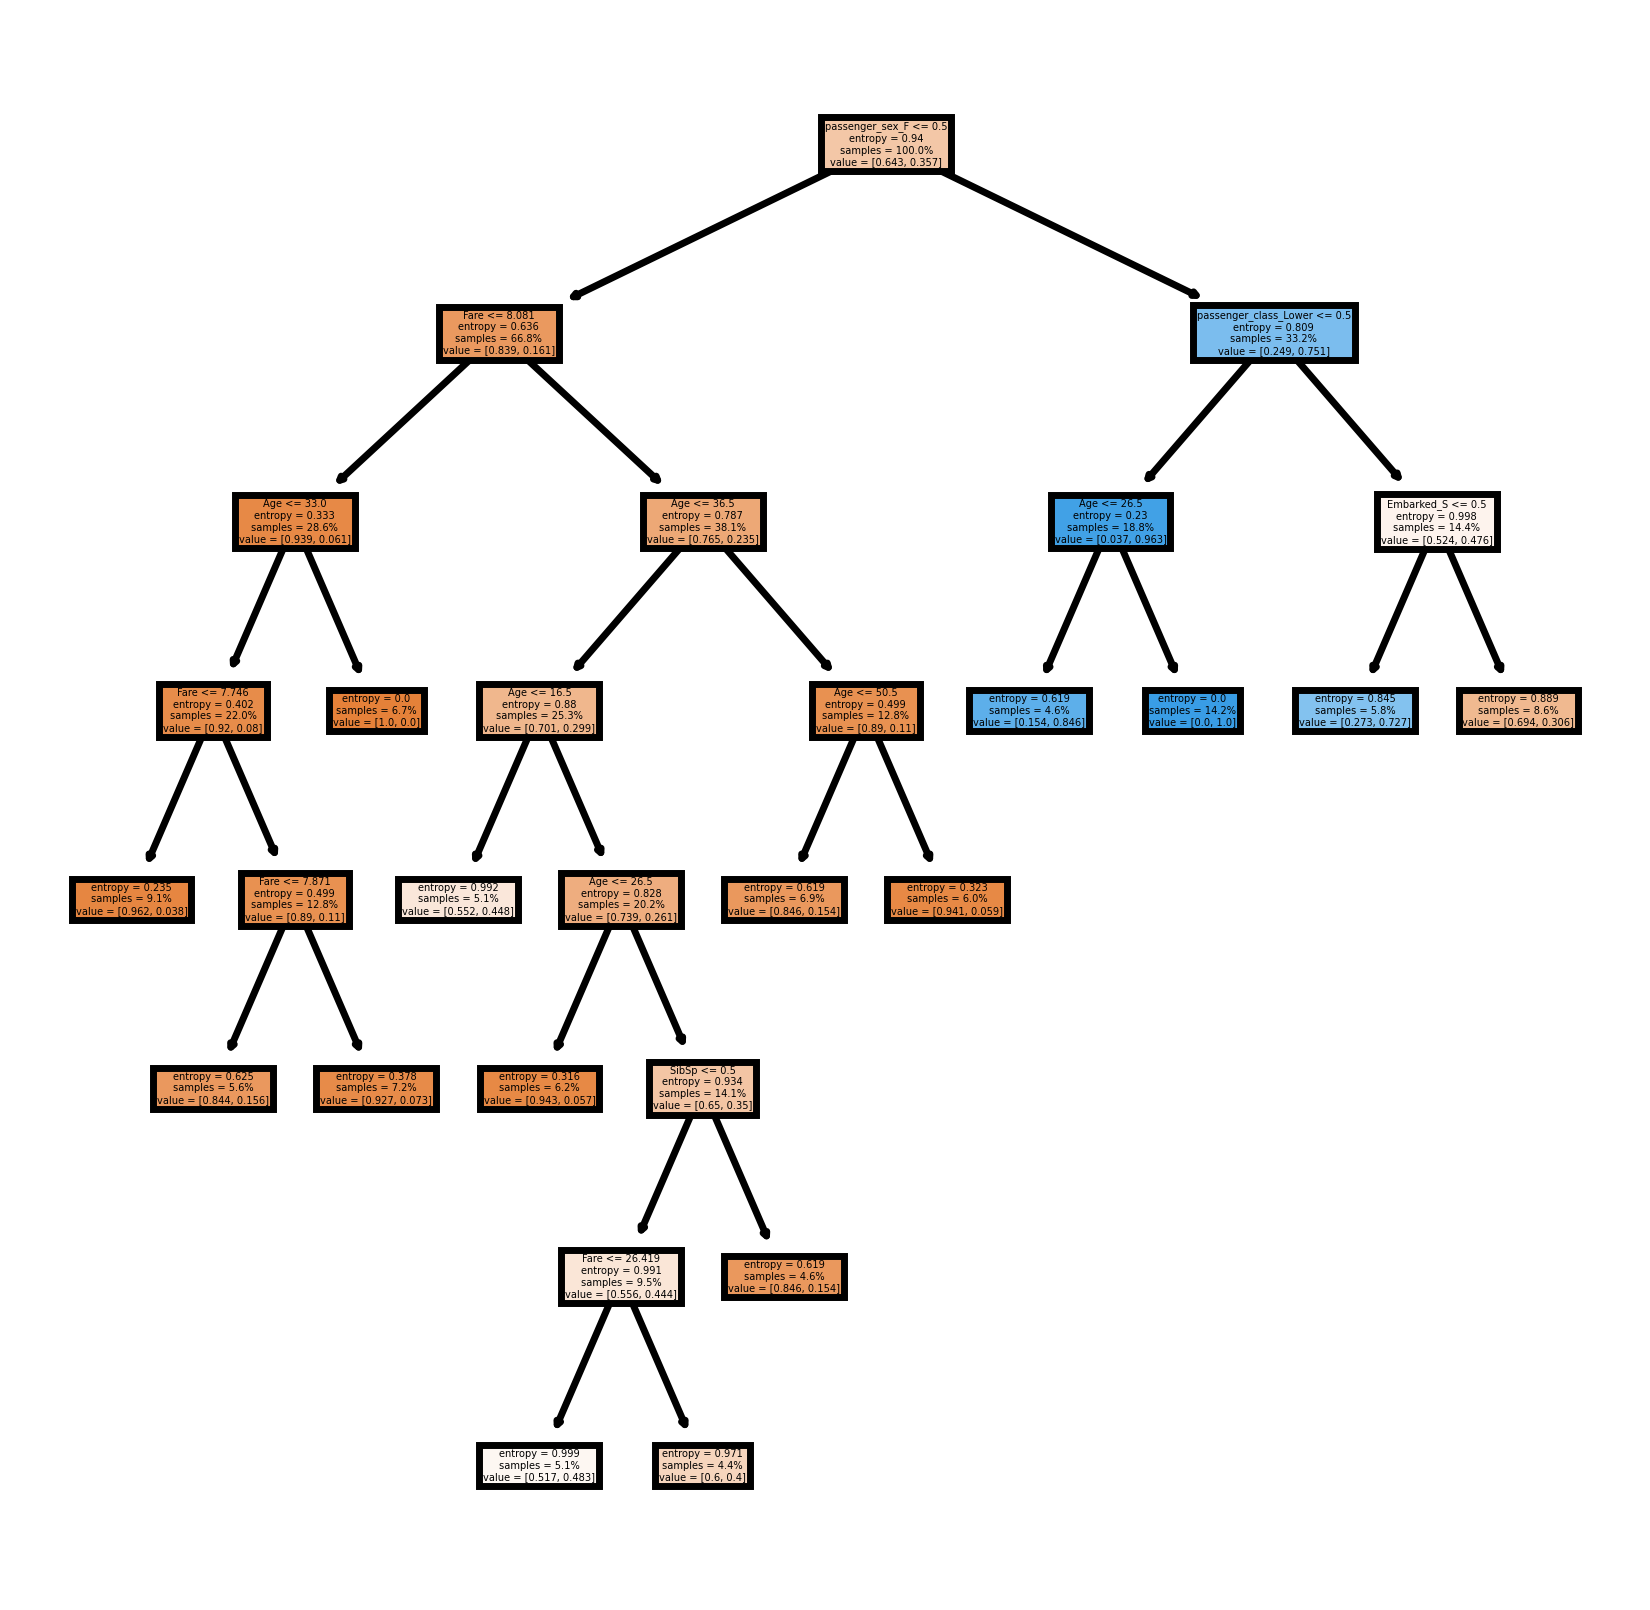

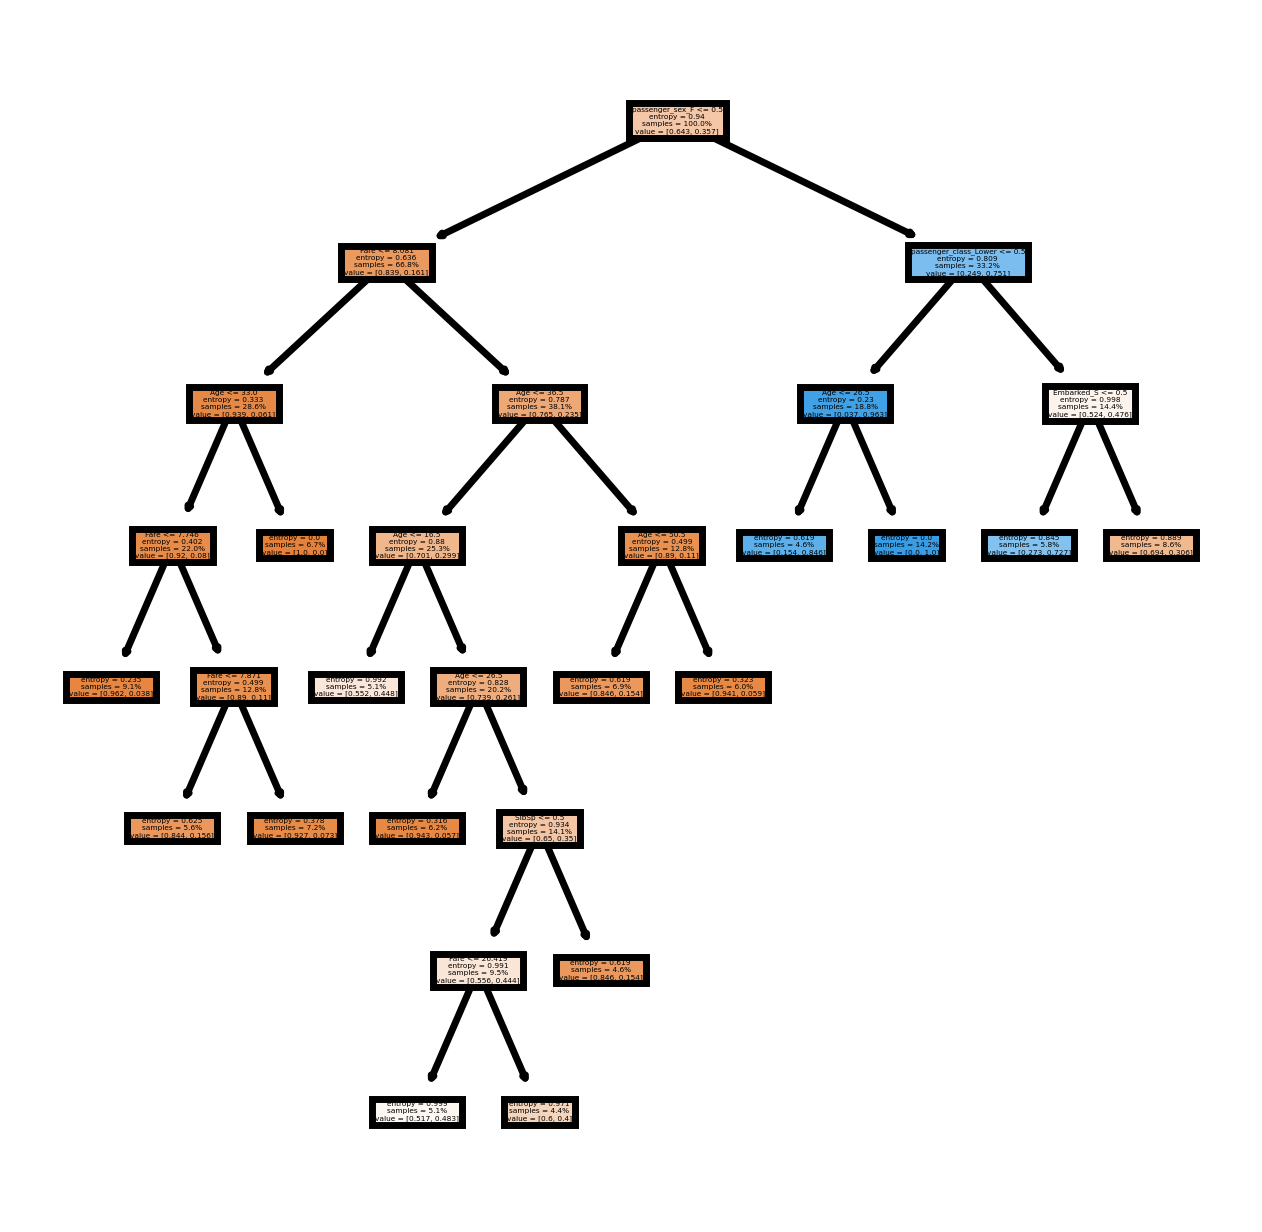

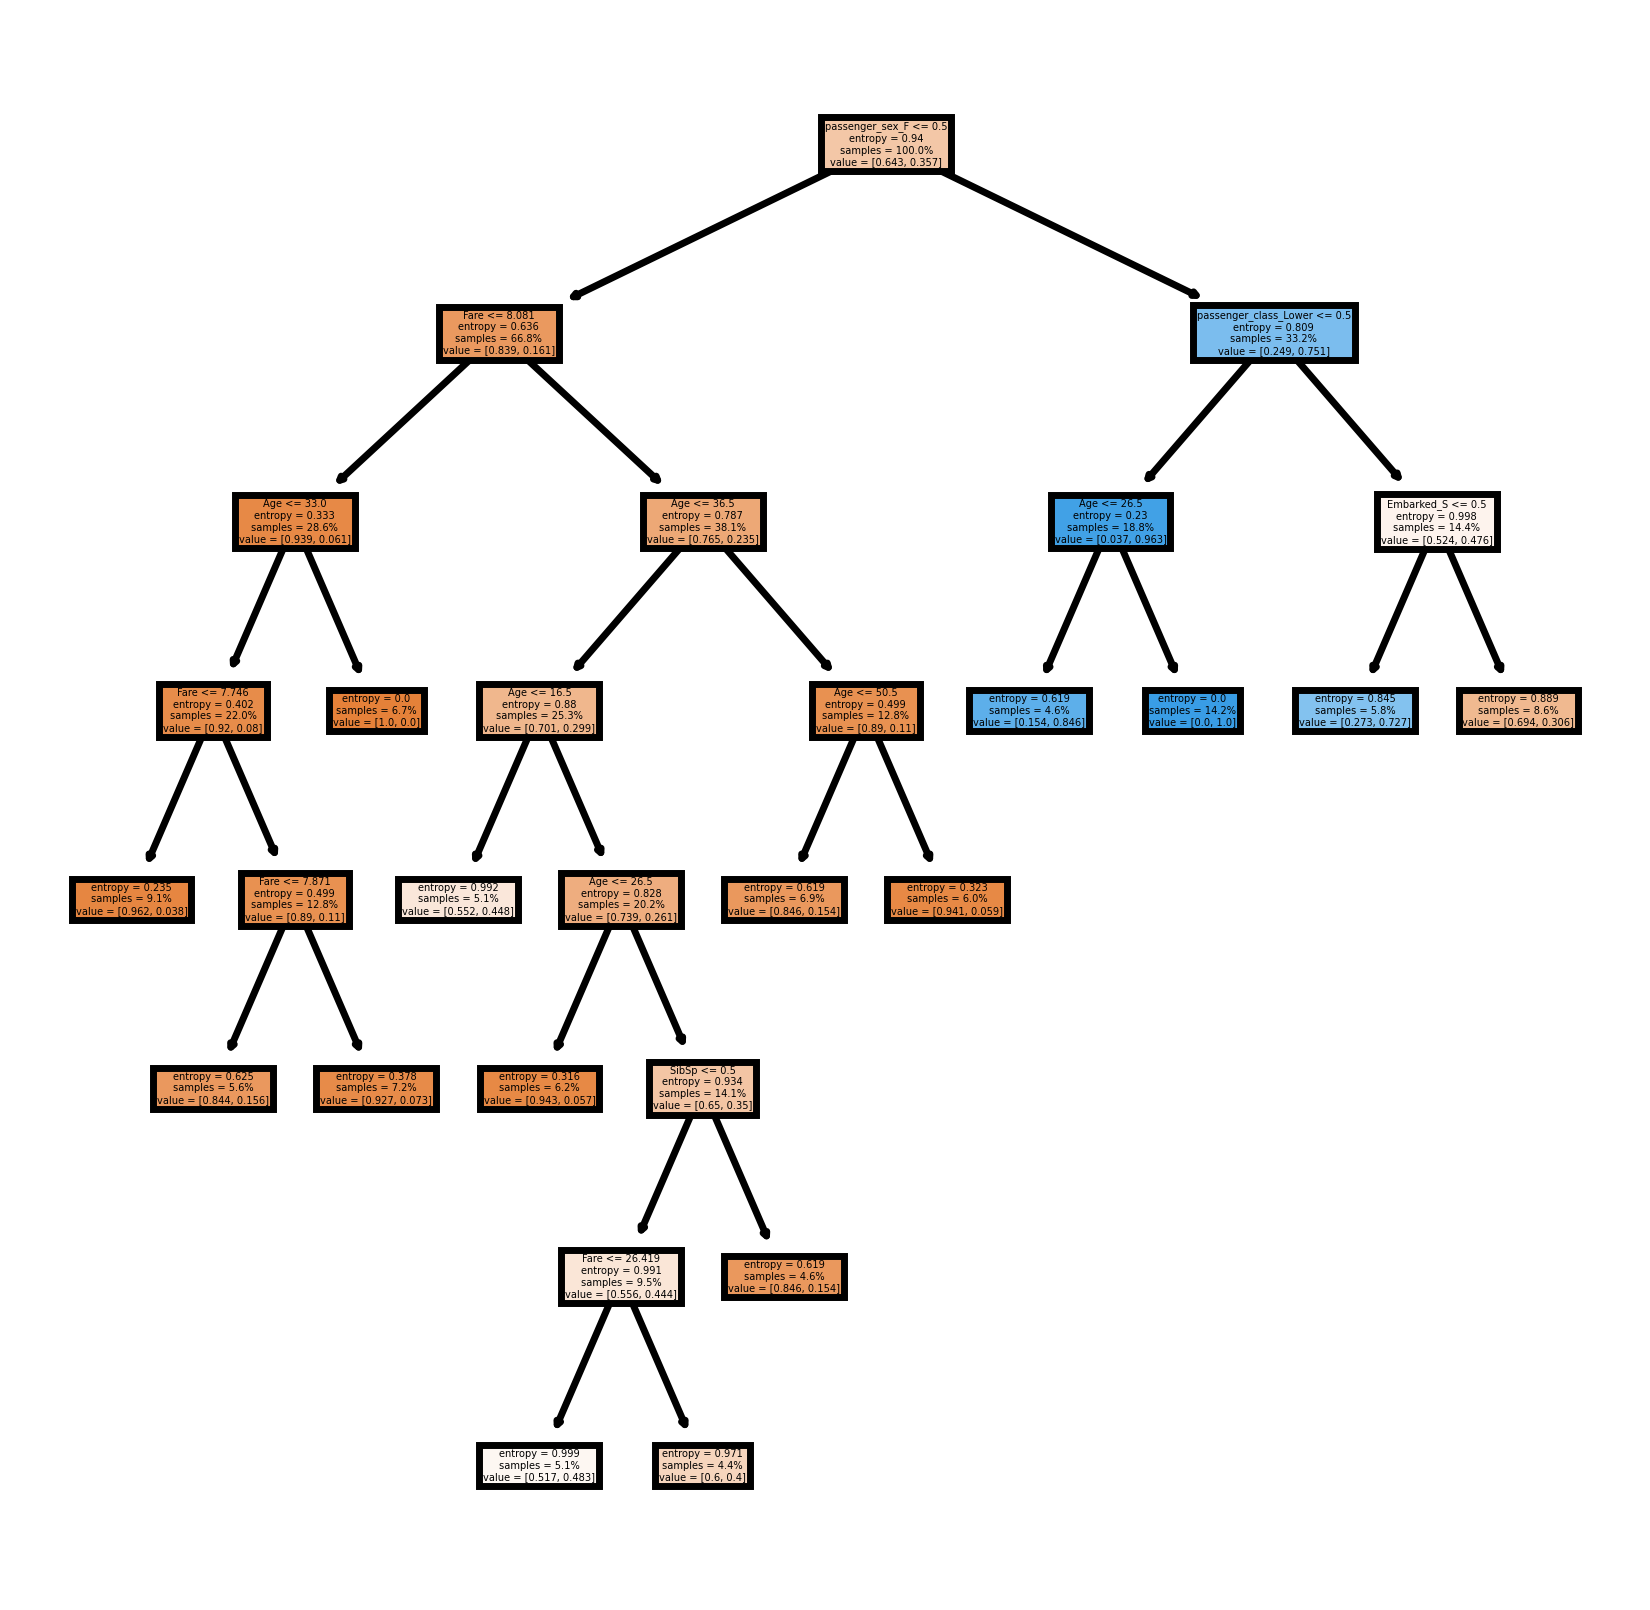

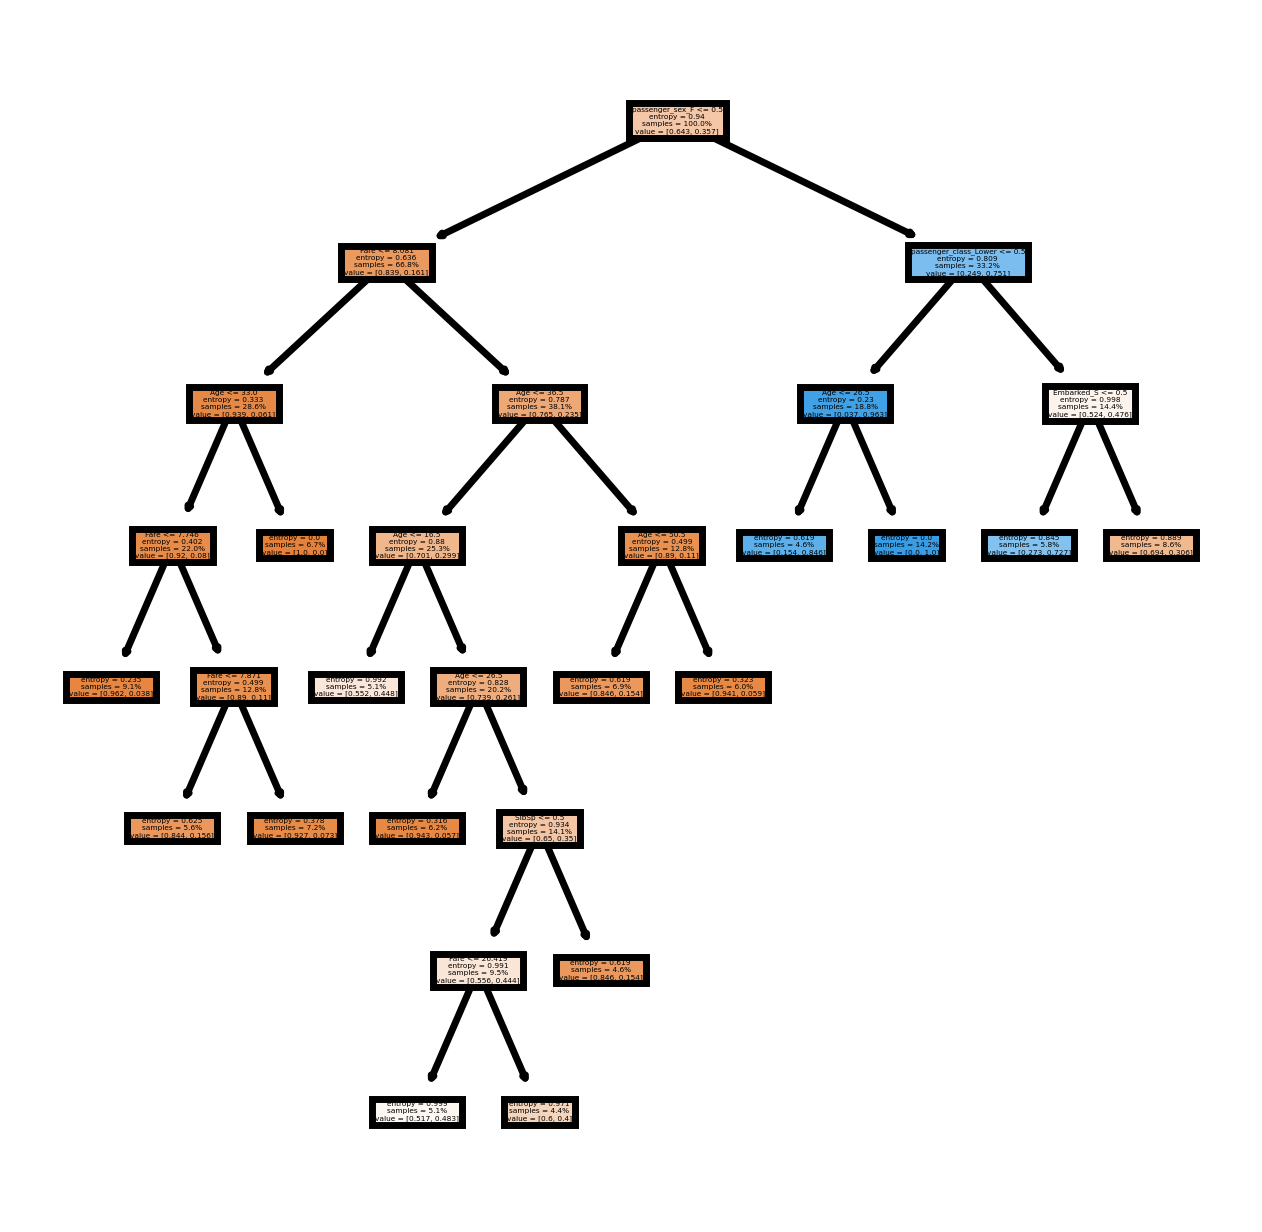

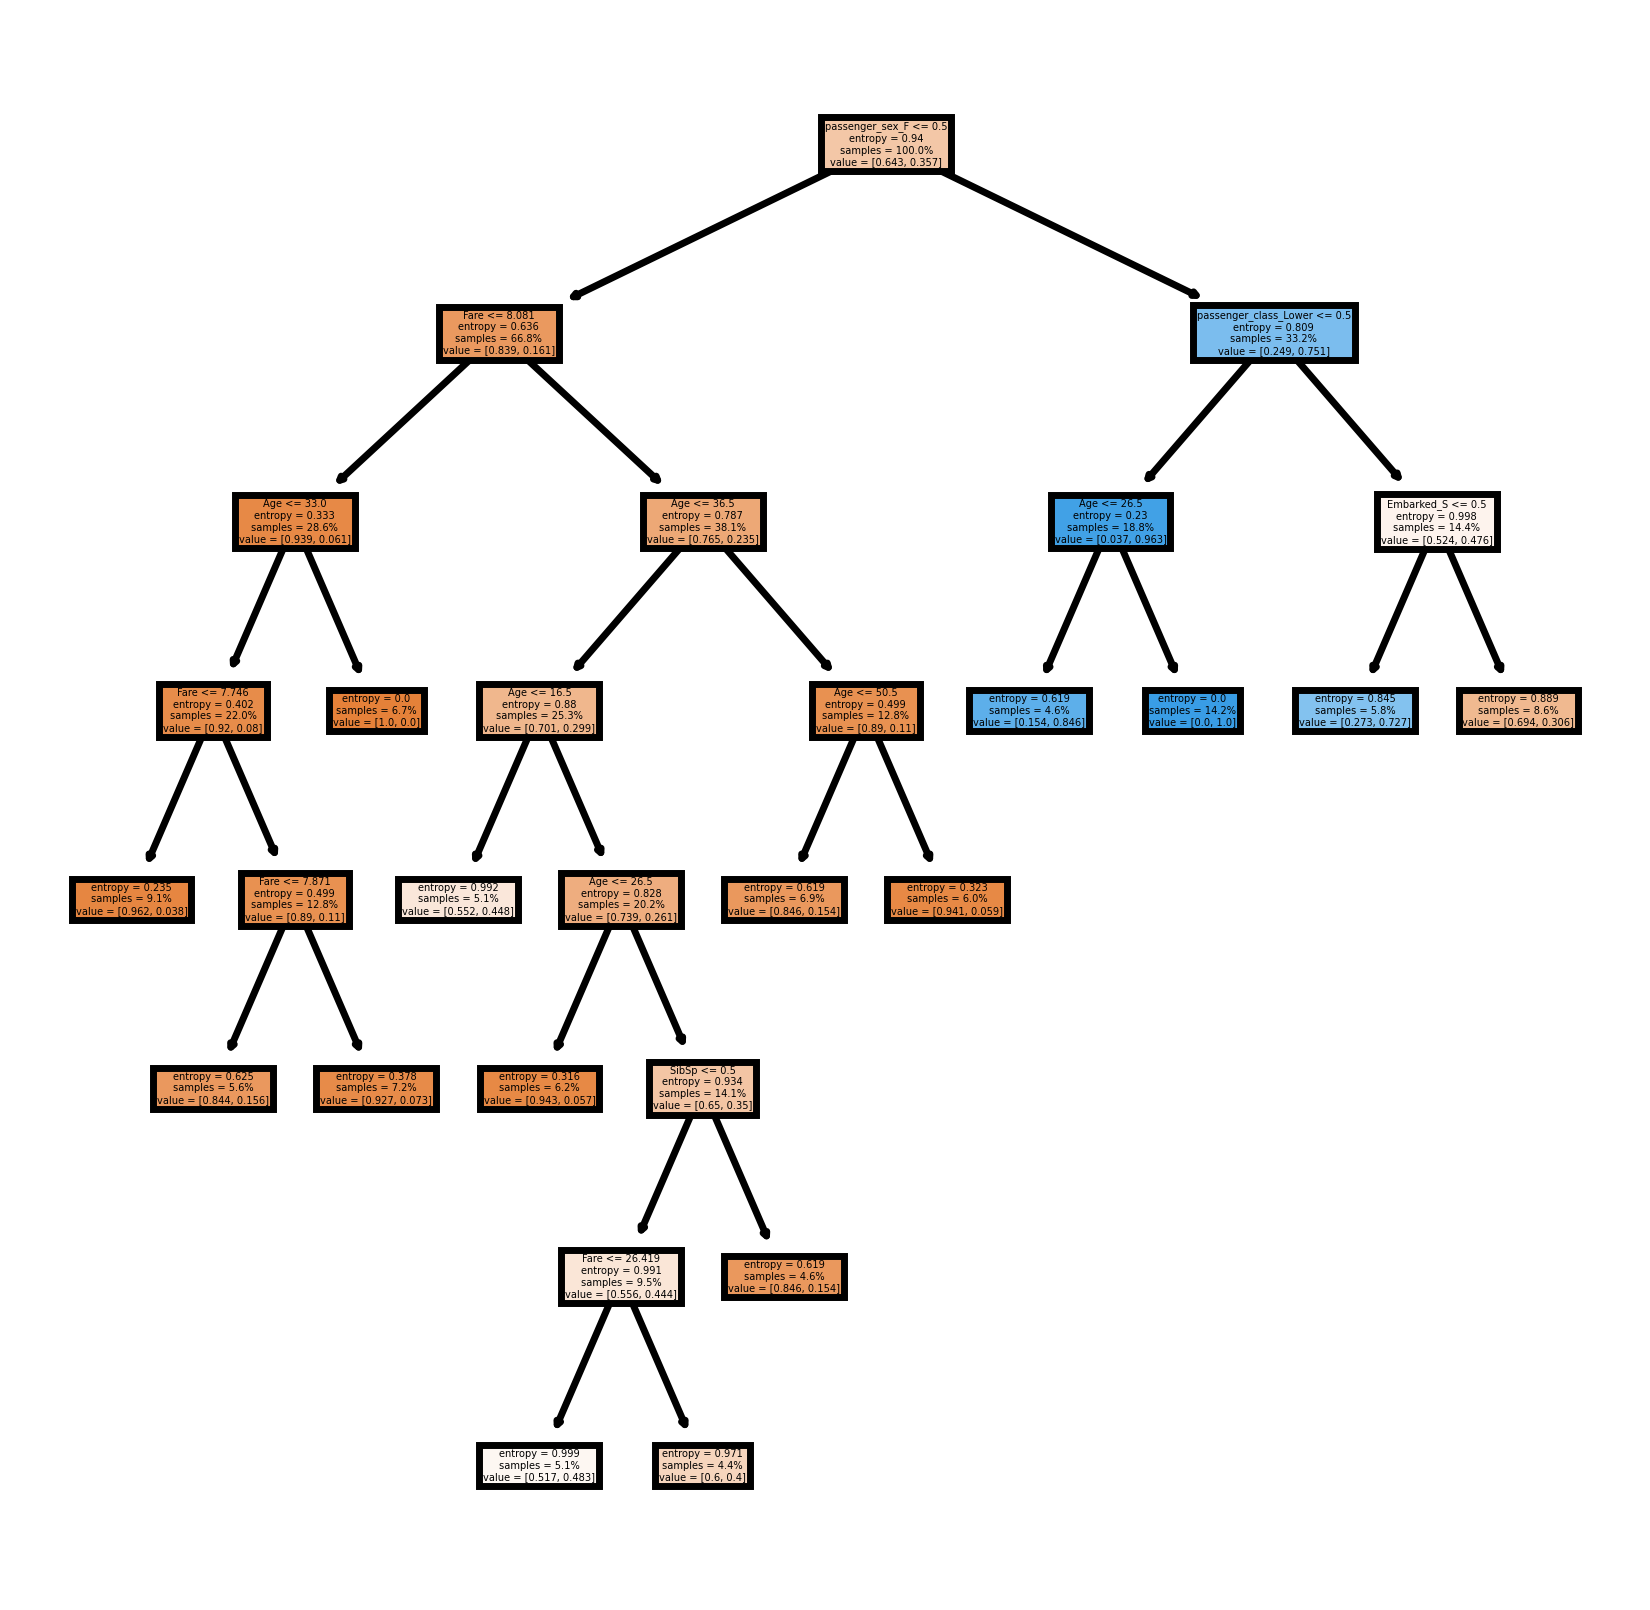

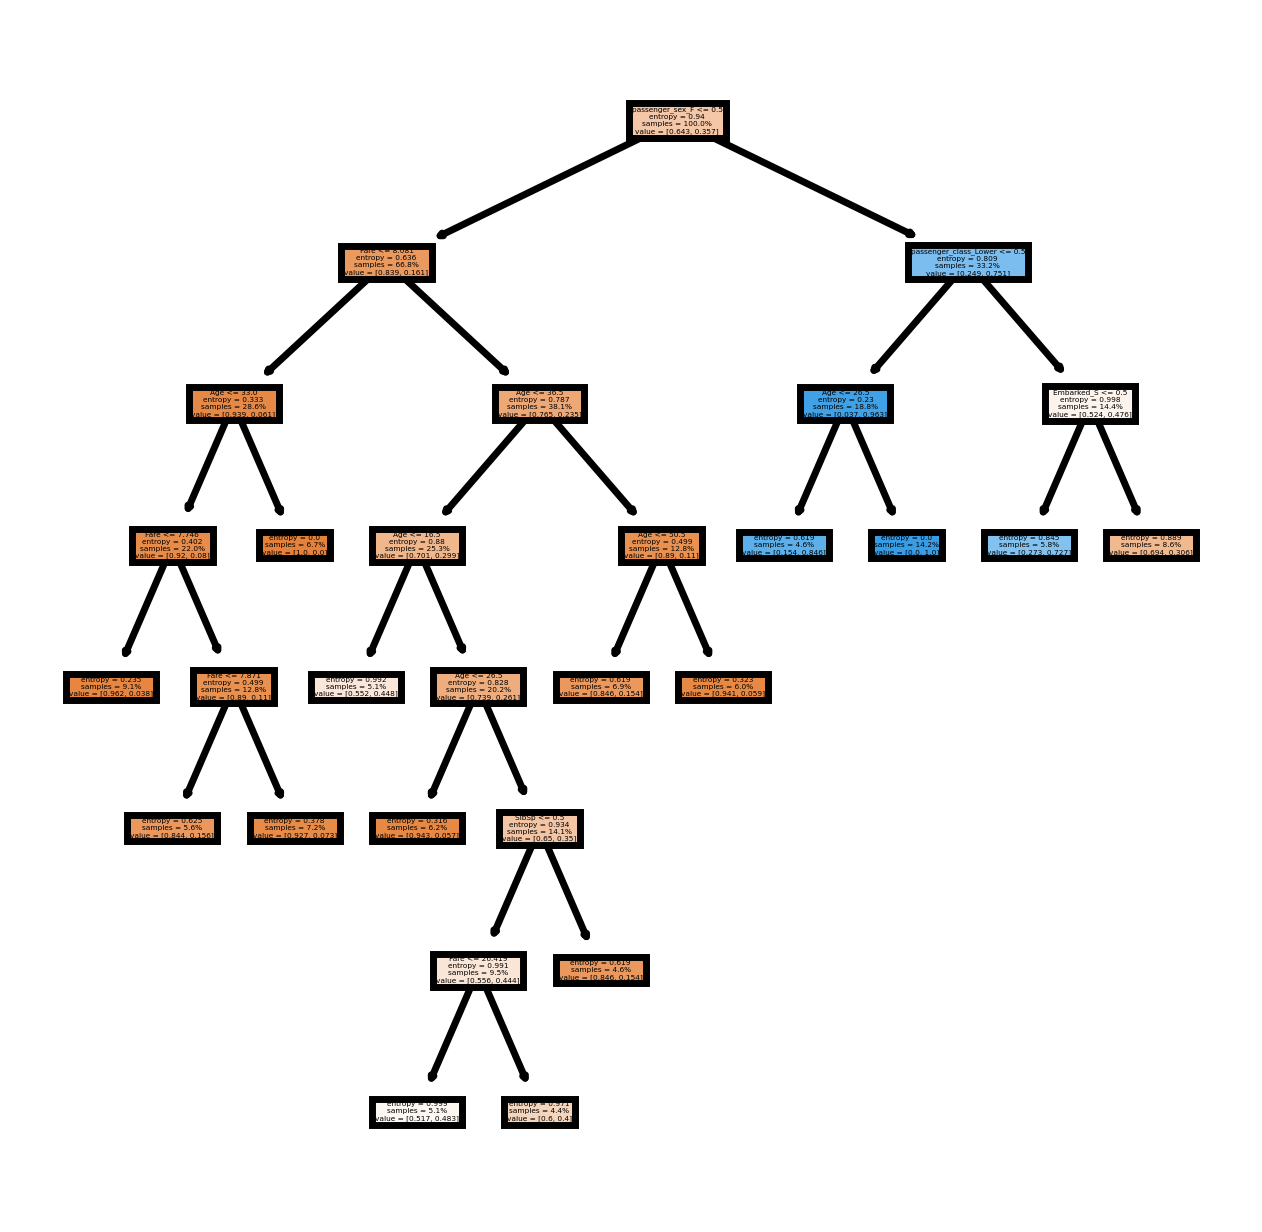

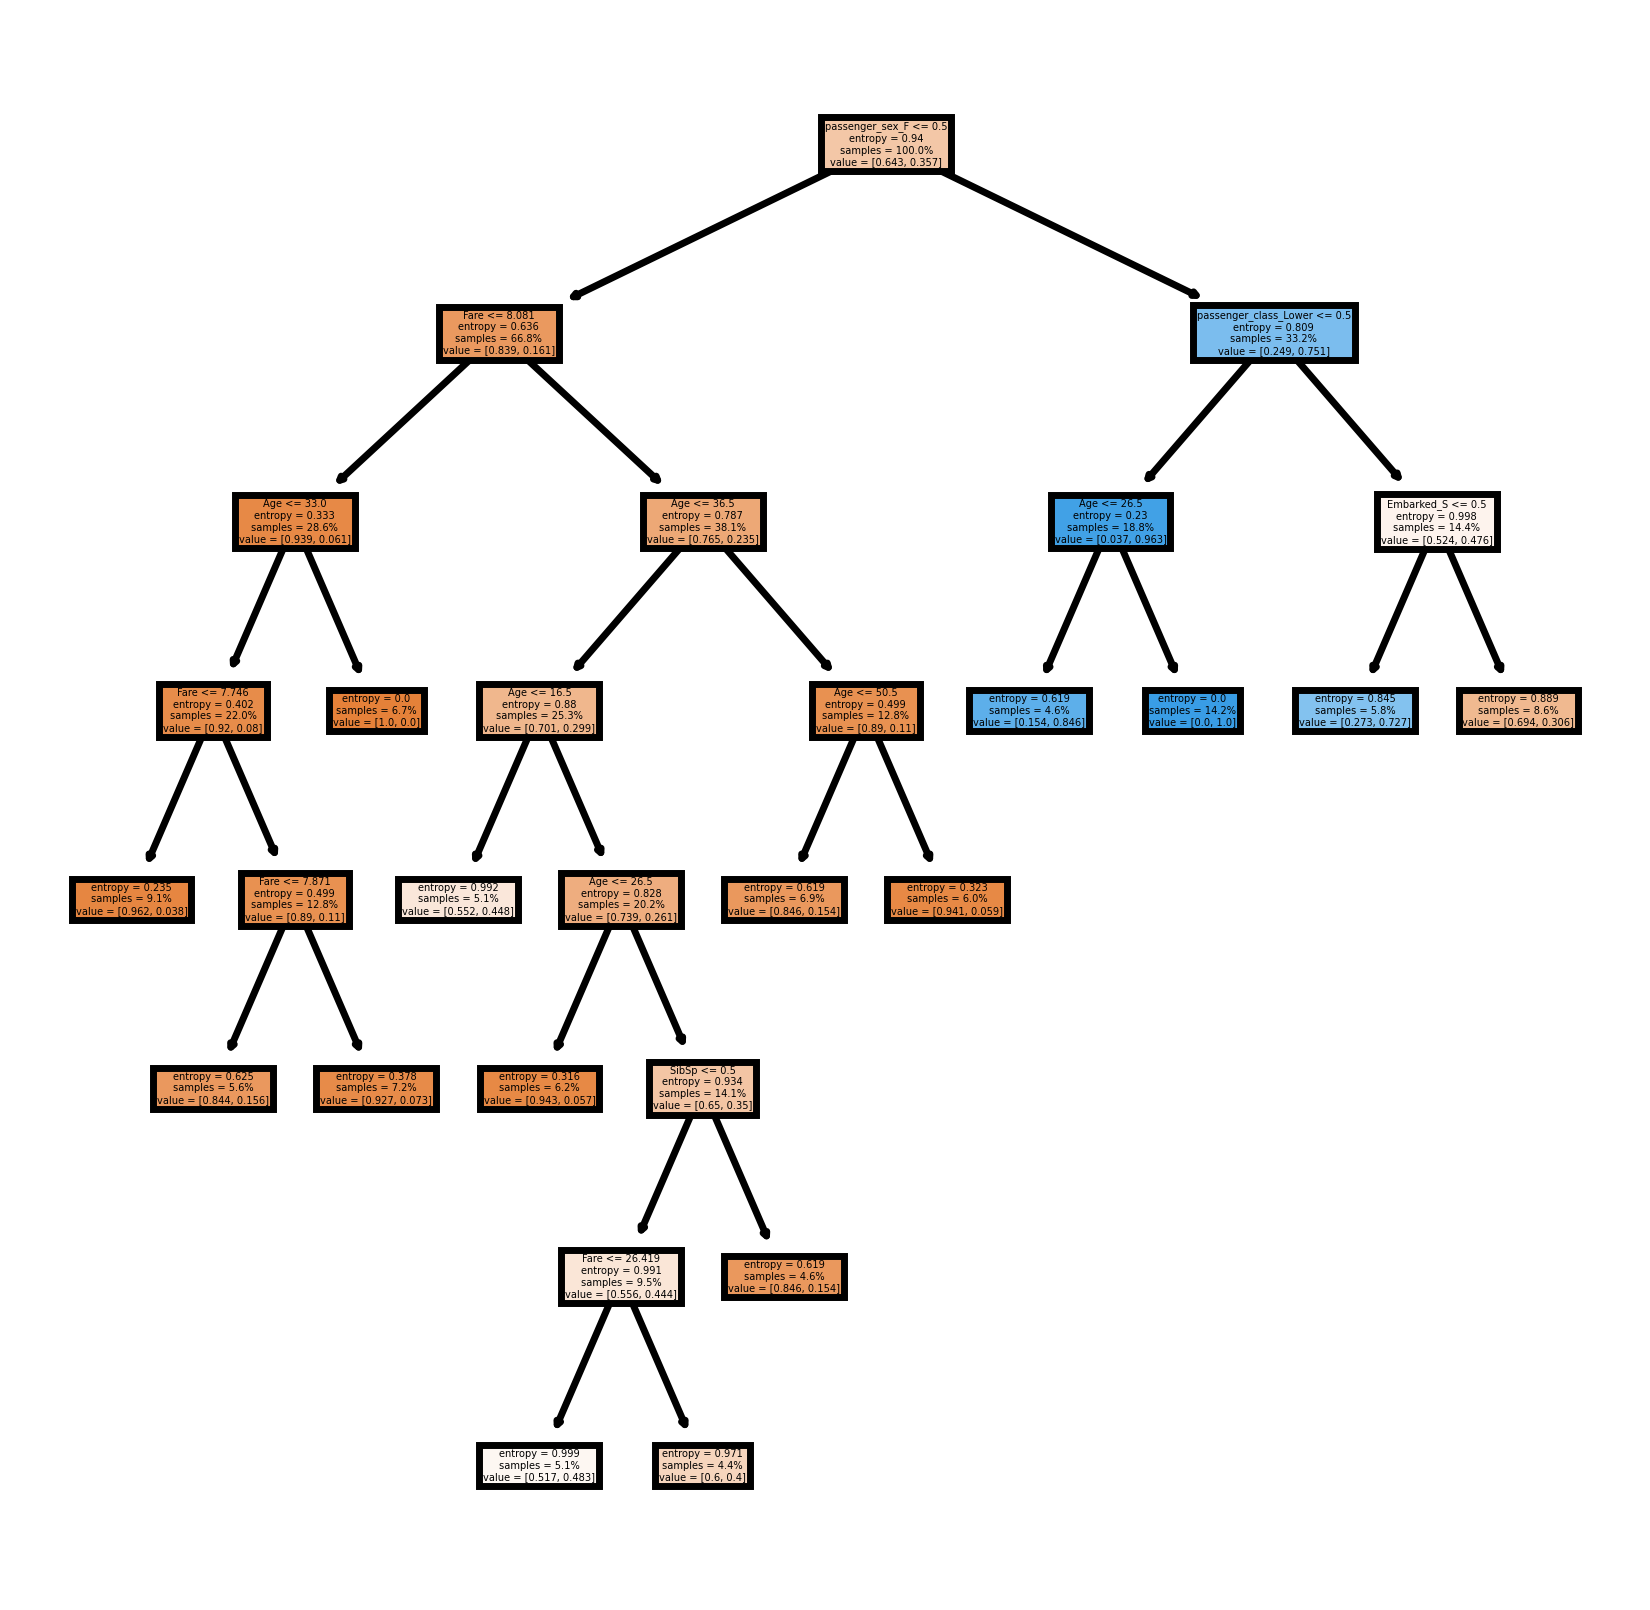

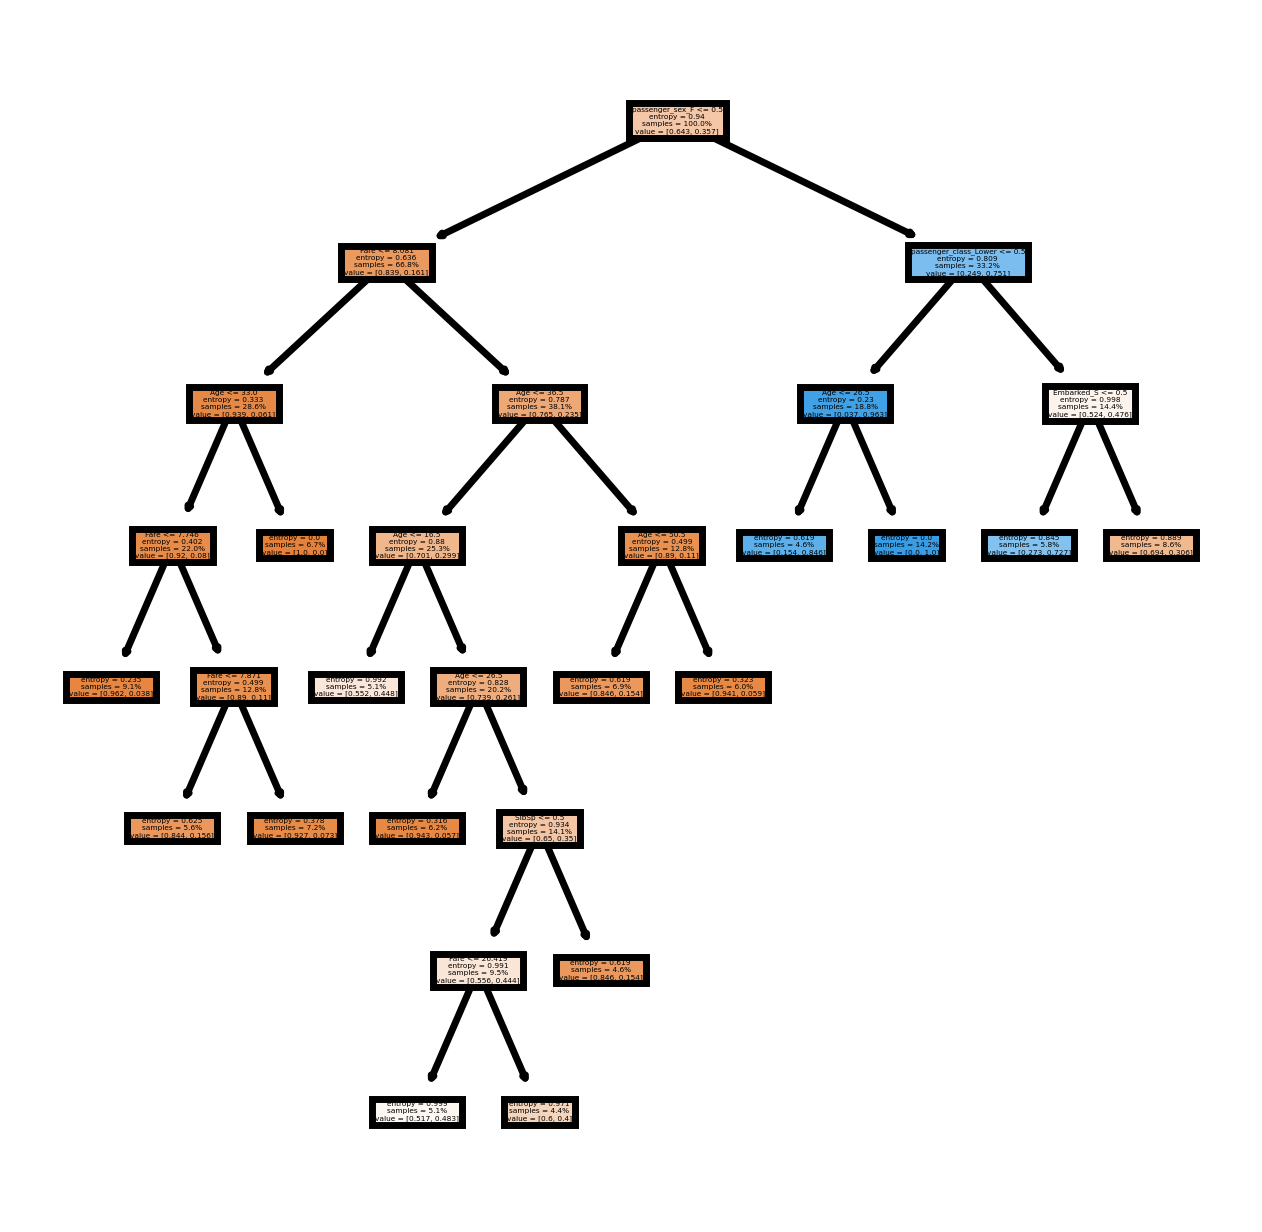

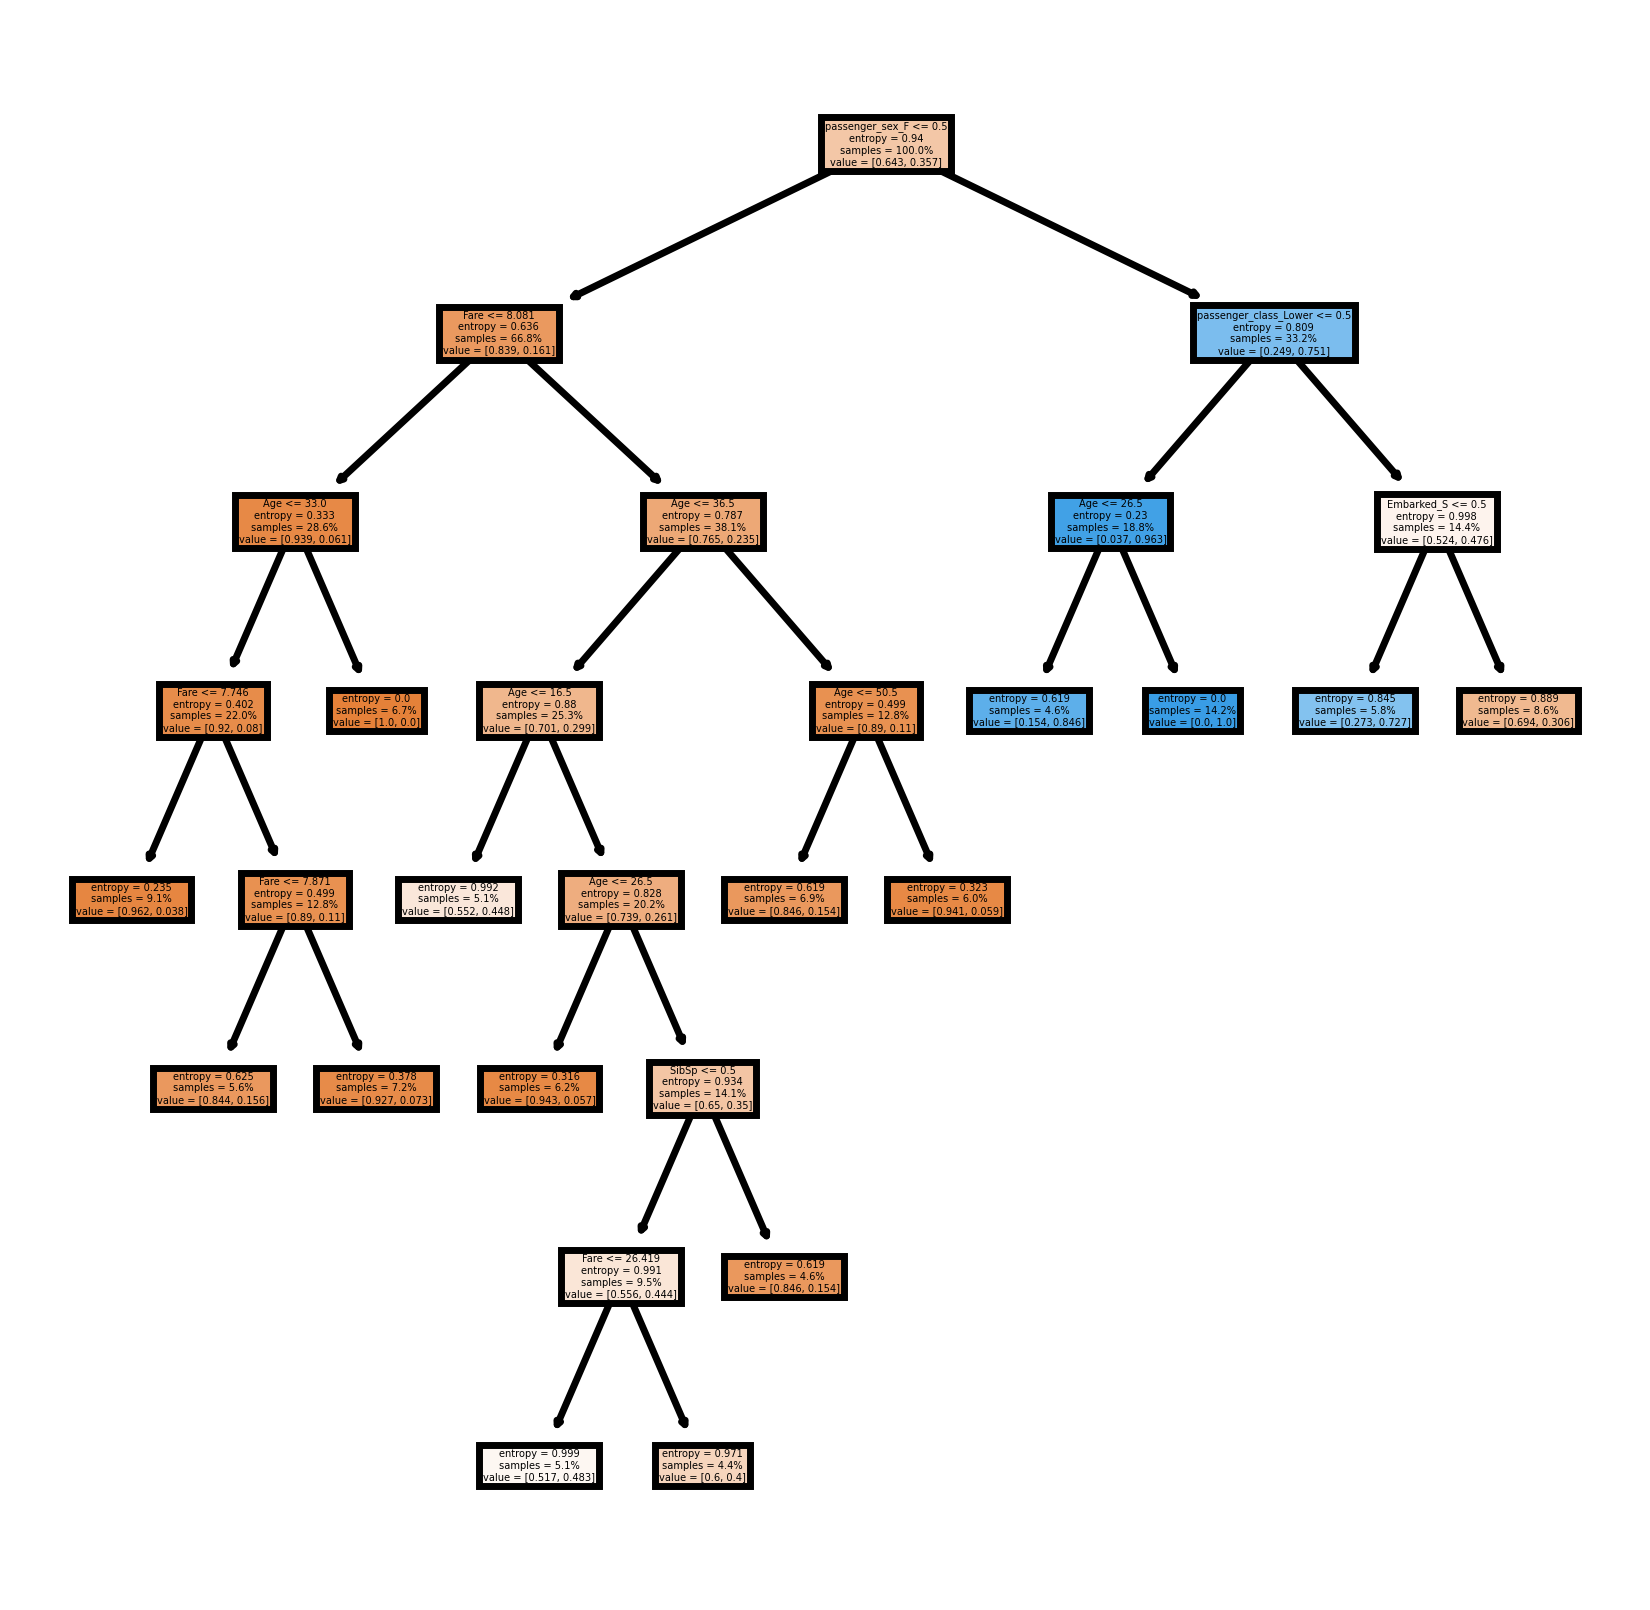

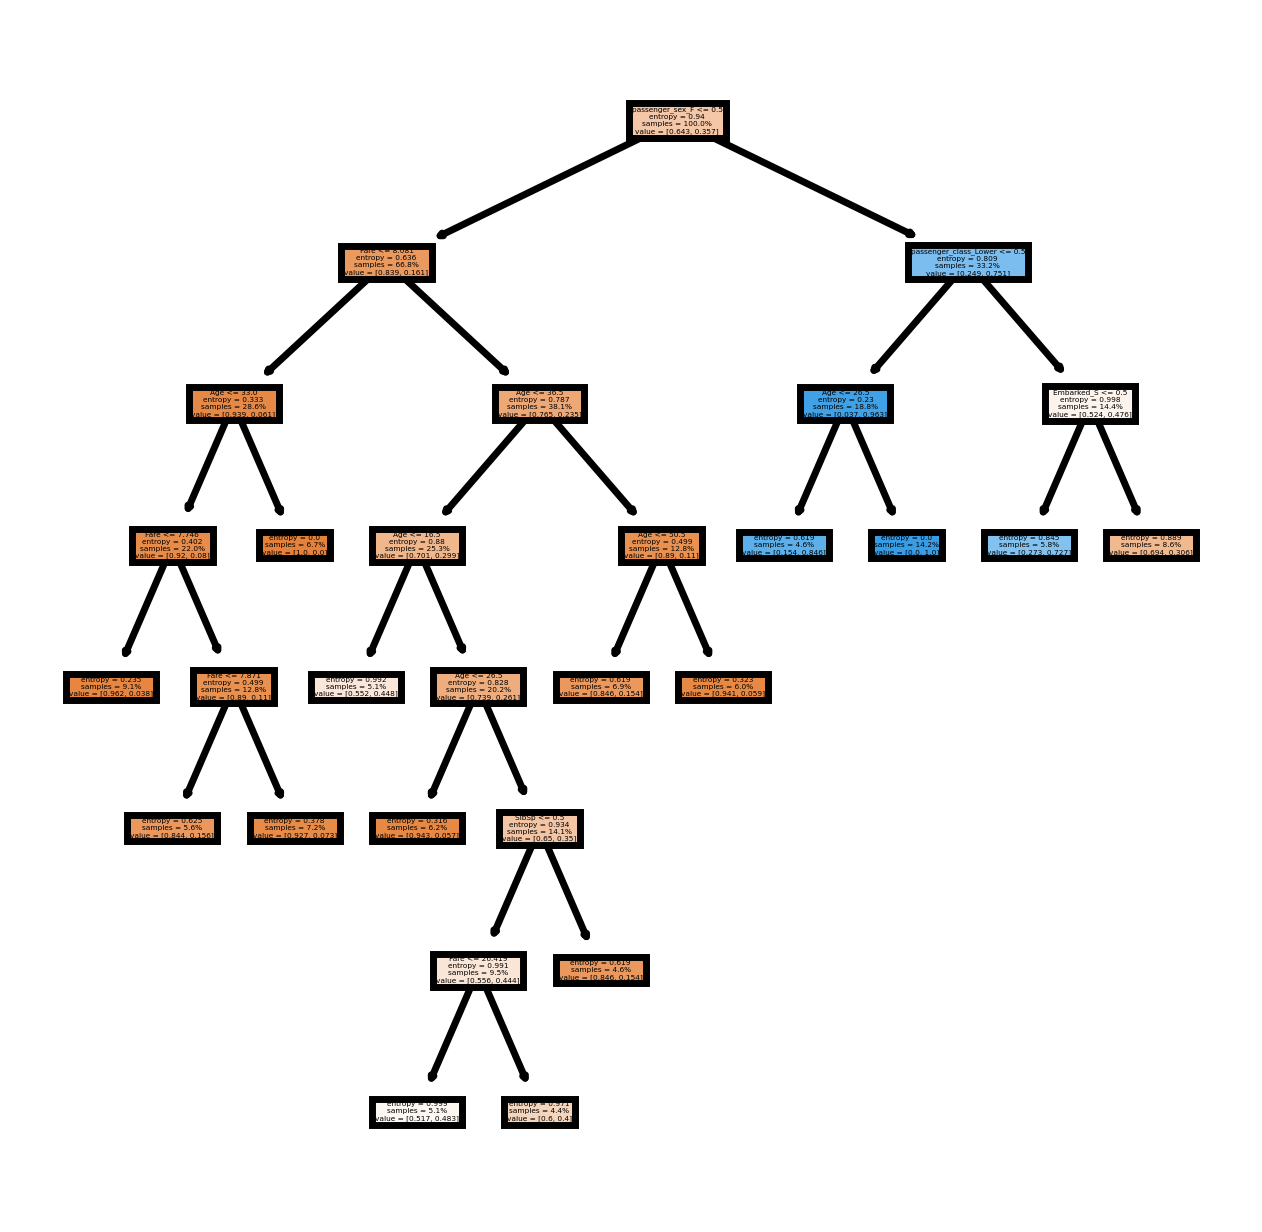

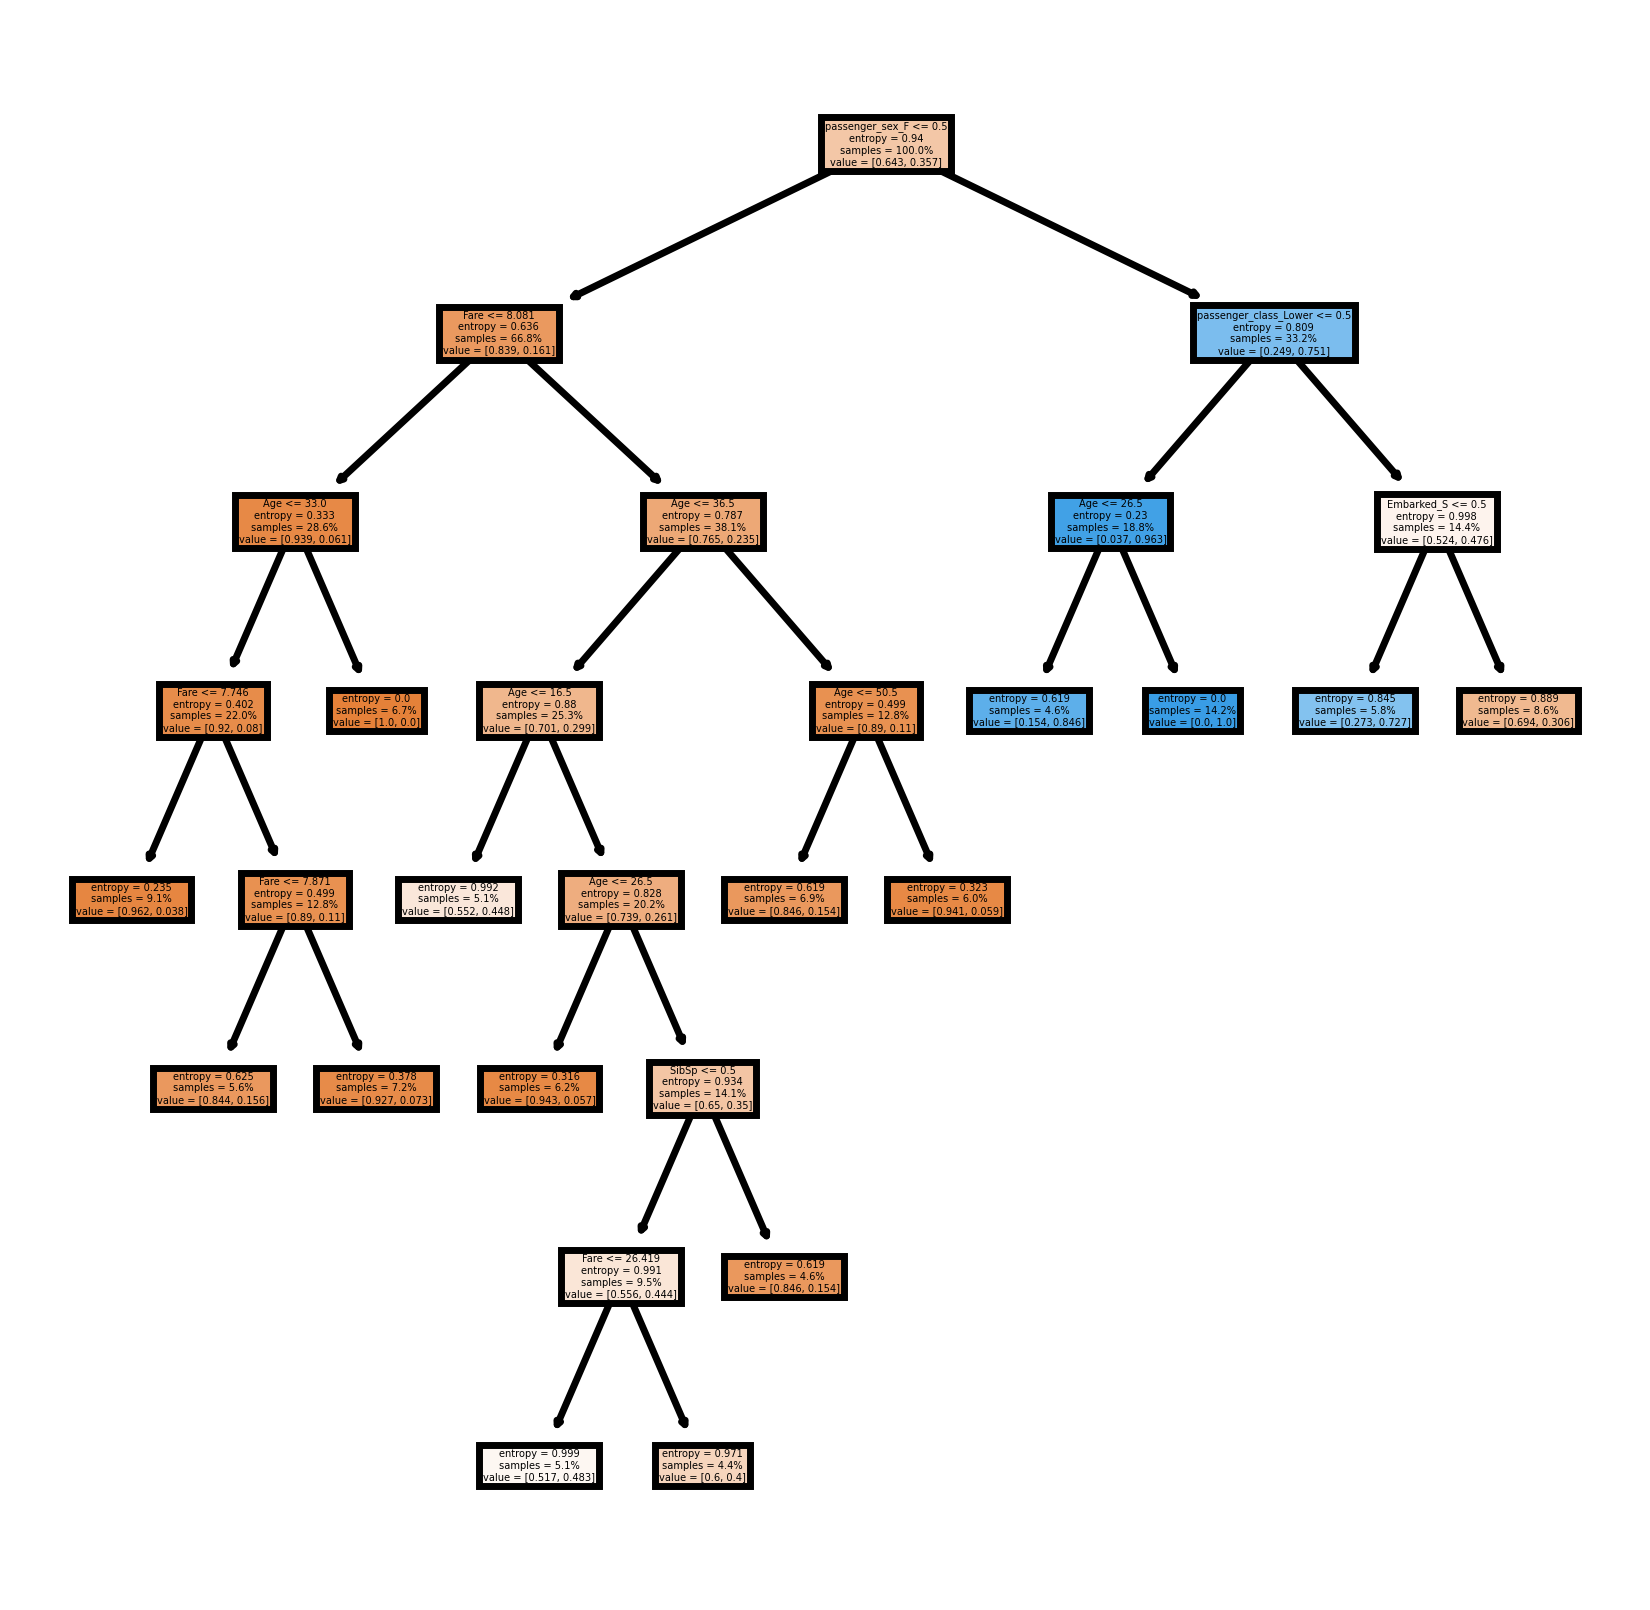

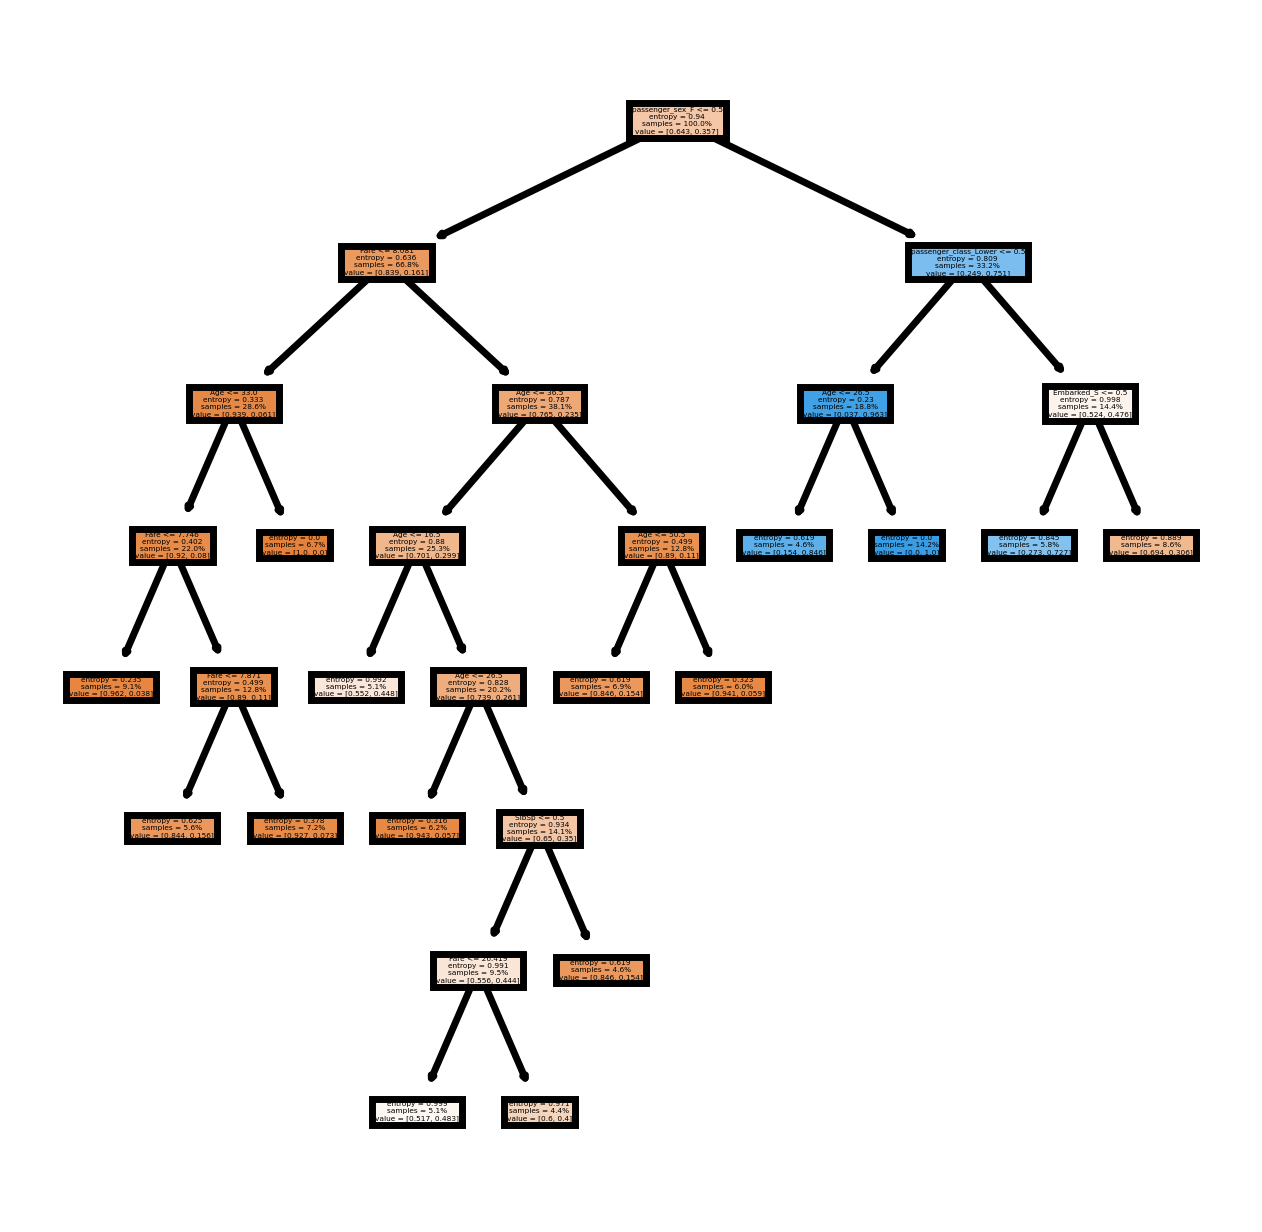

In [153]:
for i in range(0,9):
  print("\nPrediccion:",predict_y(x_test.iloc[i].values.reshape(1,12)))
  fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=500)
  plot_tree(tree, feature_names = column_names, filled = True, proportion = True)
  fig.savefig('it.png')
